In [145]:
%matplotlib inline
import numpy as np
import scipy as sci
import scipy.odr as odr
from scipy.optimize import curve_fit as cf
import pandas as pd
import matplotlib.pyplot as plt
import lmfit as lm

def dataToNpArray(data,line):
    return np.array(data.values[:,line]).astype(float)

def getValues(result):
    return list(result.best_values.values())

def getErrors(result):
    cov=np.nan_to_num(result.covar)
    return  np.sqrt(np.diag(cov)).astype(float)

def zeroTo1(data):
    returnlist=[]
    for x in data:
        if(x==0):
            returnlist.append(1)
        else:
            returnlist.append(x)
    return np.array(returnlist)

## Alles Plotten

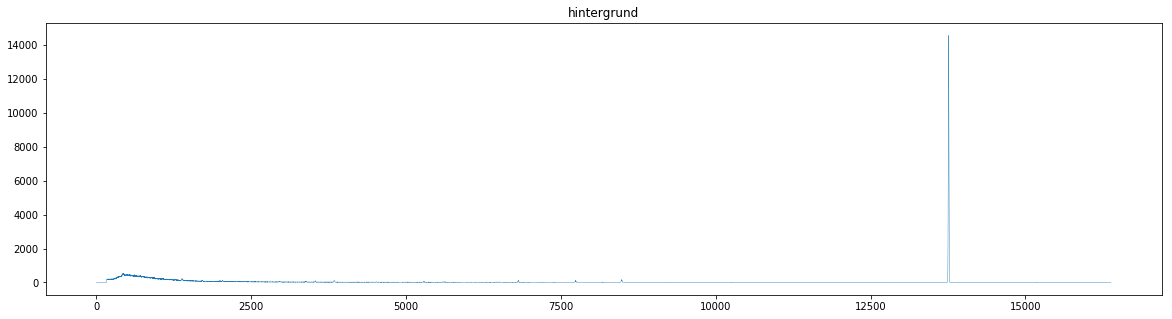

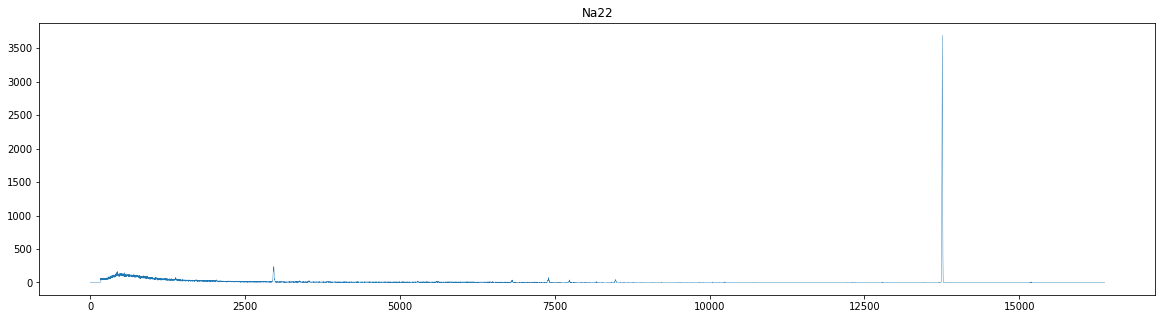

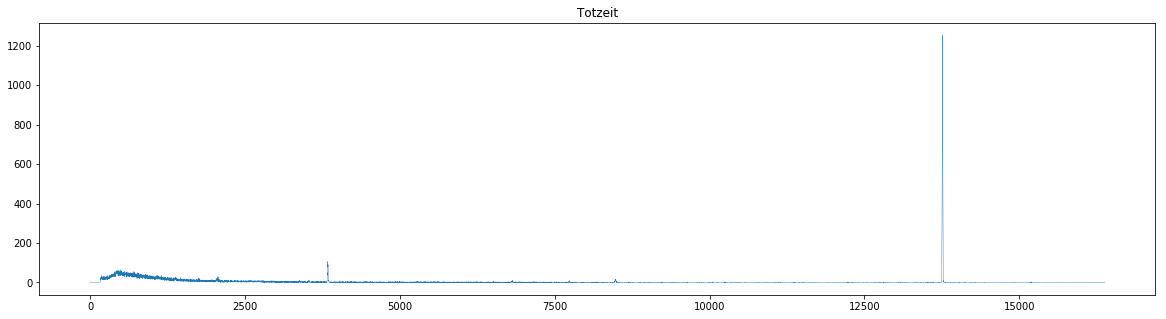

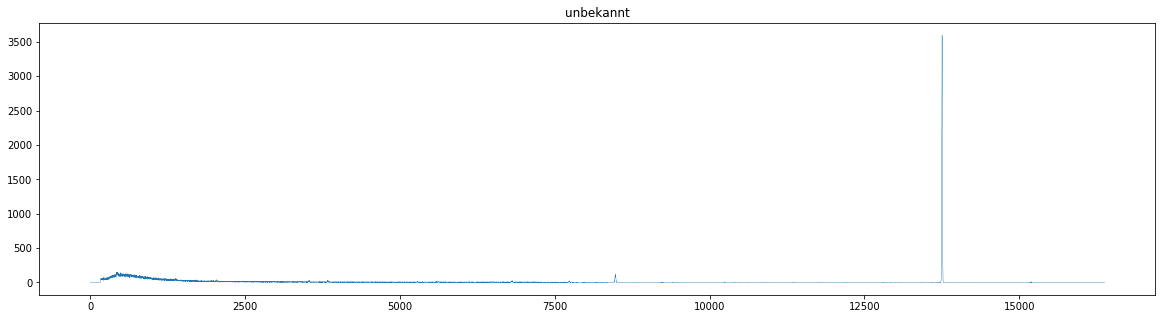

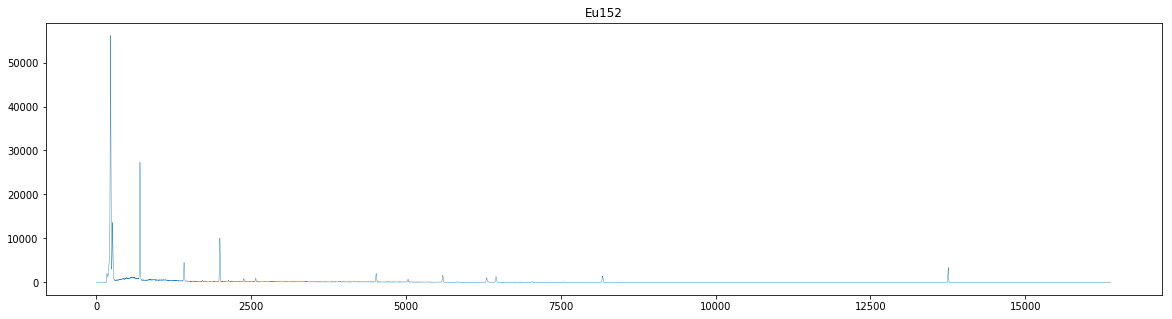

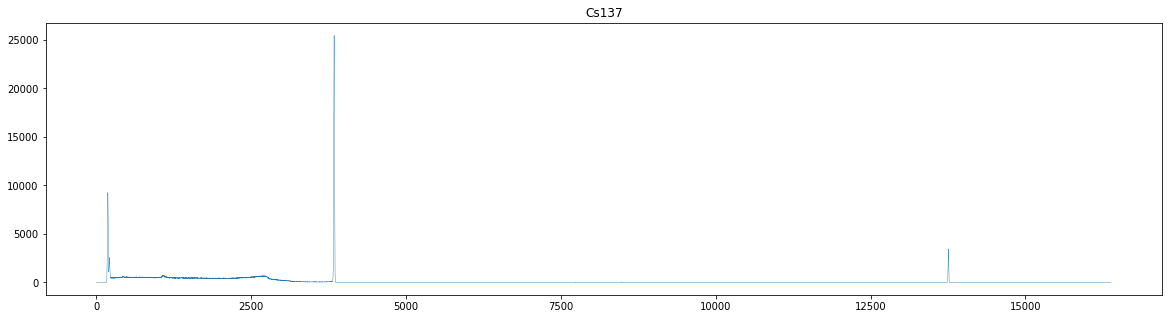

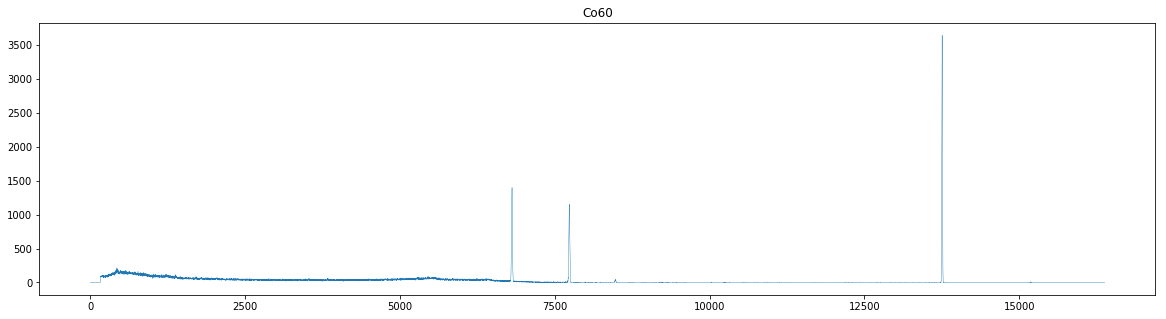

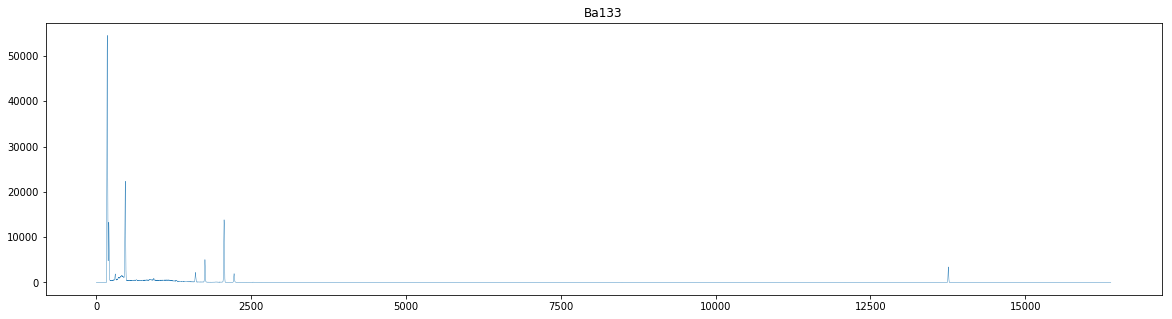

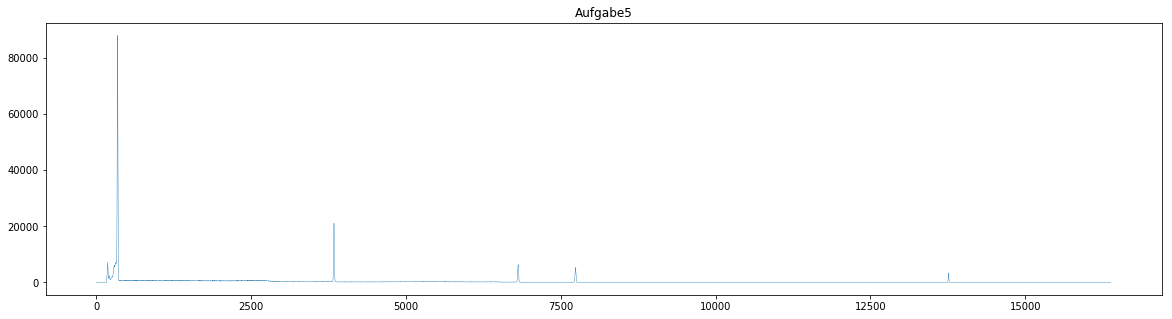

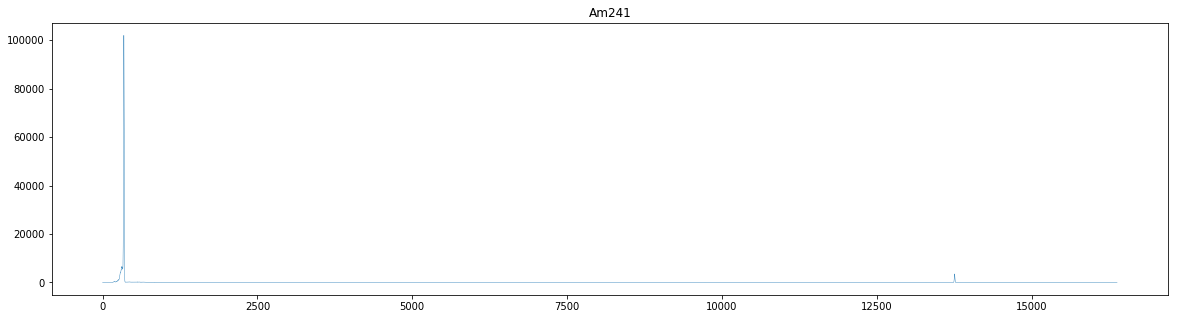

In [146]:
files=["hintergrund","Na22","Totzeit","unbekannt","Eu152","Cs137","Co60","Ba133","Aufgabe5","Am241"]
datalist=[]
messzeitList=[]
for file in files:
    name="SS18/Gr 23/{}.TKA".format(file)
    data=pd.read_table(name,skiprows=0)
    values=dataToNpArray(data,0)
    messzeitList.append(values[0])
    values=values[1:]
    datalist.append(values)
    fig,ax=plt.subplots(figsize=(20,5))
    ax.plot(range(len(values)),values,"-",lw=.4)
    #ax.semilogy()
    ax.set_title(file)
    #ax.set_xlim(0,2000)

datadict=dict(zip(files,datalist))
messzeitdict=dict(zip(files,messzeitList))

# Totzeitkorrektur für alle Plots:

In [147]:
def findpeaks(data,minval, width,fit=True,plot=False,lower=0,lookformore=0):
    """Sucht nach allen Peaks in einer Datei die größer sind als minval
    data: daten in denen gesucht wird
    minval: Ab diesem Wert wird es als Peak erkannt
    width: Breite links und rechts von minval des peaks
    fit: momentan egal
    plot: sollen die Daten geplottet werden? (default=True)
    
    
    returns: list[leftbound,righbound]
    """
    leftbound=-1
    rightbound=-1
    returnlist=[]
    for i in range(len(data)):
        #breite finden die größer ist als der angegebene wert
        
        #lookformore entscheidet, ob man mehrere werte hintereinander braucht, die über dem peak liegen
        if(data[i]>minval and leftbound==-1 and lookformore==0):
            leftbound=i-width+lower
            
        if(data[i]<minval and leftbound !=-1 and rightbound==-1 and lookformore==0):
            rightbound=i+width+lower
            returnlist.append([leftbound,rightbound])
            leftbound=-1
            rightbound=-1
            
        
        if(data[i]>minval and leftbound==-1 and lookformore!=0):
            if(lookForMore(data,minval,i,lookformore)):
                leftbound=i-width+lower


        if(data[i]<minval and leftbound !=-1 and rightbound==-1 and lookformore!=0):
            if(lookForMore(data,minval,i,-lookformore)):
                rightbound=i+width+lower
                returnlist.append([leftbound,rightbound])
                leftbound=-1
                rightbound=-1
        
        
        
    if(plot):
        for elms in returnlist:
            leftbound=elms[0]
            rightbound=elms[1]
            fig,ax=plt.subplots()
            ax.plot(range(leftbound,rightbound),values[leftbound:rightbound])
    if(fit):
        pass
    return returnlist

def lookForMore(data,value,point,width):
    if(width>0):
        for i in range(point,point+width):
            if(data[i]<value):
                return False
    else:
         for i in range(point,point+abs(width)):
            if(data[i]>value):
                return False
    return True
#Fit Model
def Gaus(x,mu,sigma,A,b):

    return(A*np.exp(-(x-mu)**2/(2*sigma**2))+b)



def calcAbsCounts(lower,upper,args):
    """Integriert über Gaus in den grenzen von lower und upper"""

    #integ=lambda x,mu,sigma,A,b:A*np.exp(-(x-mu)**2/(2*sigma**2))+b
    abscounts= sci.integrate.quad(Gaus,lower,upper,args=(*args[:3],0))
    return abscounts

['mu', 'sigma', 'A', 'b']
(179498.57129547154, 1.8751308518819652e-07)
sum 179725.0
(44798.421236679984, 3.242275683179684e-08)
sum 44920.0
(14884.176808151551, 4.273310825142387e-05)
sum 14966.0
(44798.205646686656, 0.0005390815267472647)
sum 44919.0
(42408.63403011999, 0.00038293416583892417)
sum 43009.0
(43339.37943139826, 0.00017726255907362764)
sum 43714.0
(44571.69280941014, 0.0006299436933399638)
sum 44727.0
(43290.25422900542, 2.501617467049201e-08)
sum 43772.0
(40923.92048063123, 0.00017471340616885208)
sum 42204.0
(43475.56102844415, 5.88518281657514e-05)
sum 44004.0


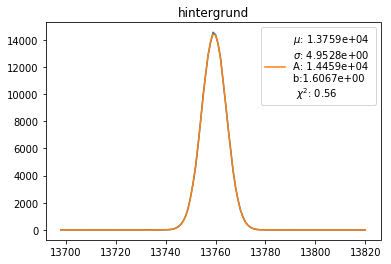

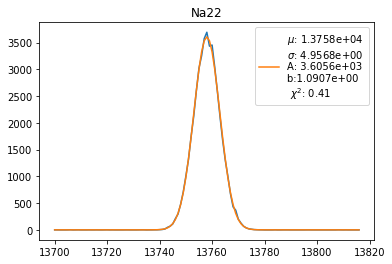

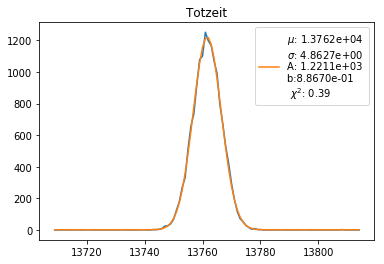

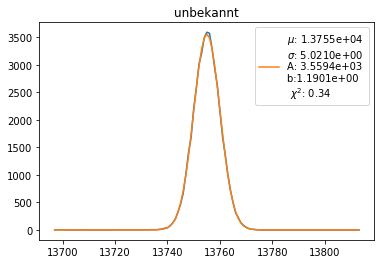

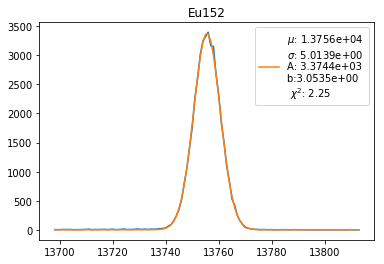

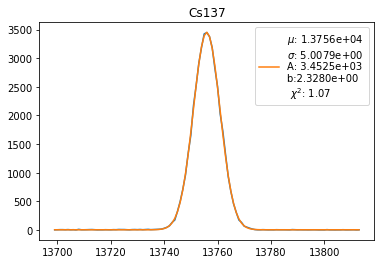

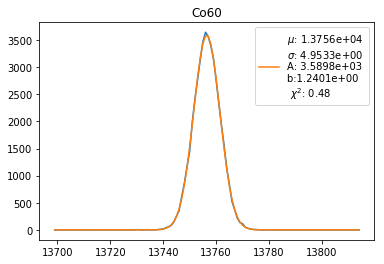

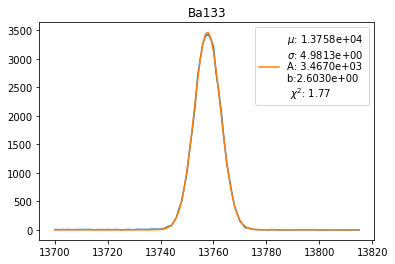

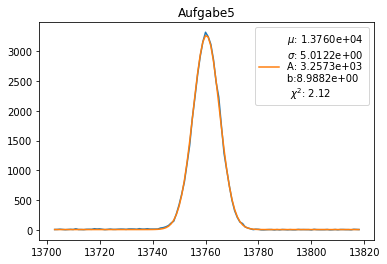

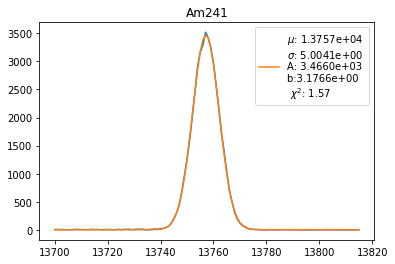

In [148]:
gmodel=lm.Model(Gaus)
print(gmodel.param_names)
params=gmodel.make_params(mu=13760,sigma=1,A=2,b=0)
fitvals=[]
integratedGausList=[]
for file in datadict:
    data=datadict[file]
    messzeit=messzeitdict[file]
    lower=13700
    upper=13800
    peakdata=data[lower:upper]

    bounds=findpeaks(peakdata,1000,50,fit=False,lower=lower)
    left,right=bounds[0]
    x=np.array(range(left,right))
    y=data[left:right]
    
    result=gmodel.fit(data[left:right],params,x=np.array(range(left,right)),weights=(np.sqrt(y))/zeroTo1(y))

    best_fitvals=list(result.best_values.values())



    
    
    
    
    fitvals.append(best_fitvals)
    redchi=result.redchi#/result.best_values["sigma"]**2
    fig,ax=plt.subplots()
    #print(result.fit_report())
    ax.plot(np.array(range(left,right)),data[left:right])
    ax.set_title(file)
    ax.plot(np.array(range(left,right)),result.best_fit,c="C1",label="$\mu$: {:.4e} \n$\sigma$: {:.4e}\nA: {:.4e} \nb:{:.4e} \n $\chi^2$: {:.2f} ".format(*result.best_values.values(),redchi))
    ax.legend()
    abscounts=calcAbsCounts(left,right,best_fitvals)
    integratedGausList.append(abscounts[0])
    print(abscounts)
    print("sum",sum(data[left:right]))


#hier eine funktion schreiben die über die Gaußkurven integriert
integratedGausDict=dict(zip(files,integratedGausList))
fitvaldict=dict(zip(files,fitvals))

In [149]:
totzeitFaktorDict={}
realMessZeitDict={}
for name in messzeitdict:
    zeit=messzeitdict[name]
    counts=integratedGausDict[name]
    frequenz=50 #In Hertz
    expectedcounts=zeit*frequenz
    faktor=counts/expectedcounts
    totzeitFaktorDict.update({name: faktor})
    realMessZeitDict.update({name: zeit*faktor})

In [150]:
print(totzeitFaktorDict)
print(realMessZeitDict)

{'hintergrund': 0.9972142849748419, 'Na22': 0.9955204719262218, 'Totzeit': 0.99227845387677, 'unbekannt': 0.9955156810374812, 'Eu152': 0.9424140895582219, 'Cs137': 0.963097320697739, 'Co60': 0.9904820624313364, 'Ba133': 0.9620056495334538, 'Aufgabe5': 0.9094204551251384, 'Am241': 0.96612357840987}
{'hintergrund': 3589.9714259094308, 'Na22': 895.9684247335997, 'Totzeit': 297.683536163031, 'unbekannt': 895.9641129337331, 'Eu152': 848.1726806023997, 'Cs137': 866.7875886279651, 'Co60': 891.4338561882028, 'Ba133': 865.8050845801084, 'Aufgabe5': 818.4784096126245, 'Am241': 869.511220568883}


## Korrektur der Hintergrundstrahlung

Die Korrektur der Hintergrundstrahlung wird mithilfe der Hintergrundmessung gemacht und dann auf alle anderen Messungen übertragen. Die Amplitudenkorrektur wird dann jeweils mithilfe der Messzeiten gemacht.

Bisher habe ich nur den vor den großen peak am anfang zu Fitten und den Rest der Peaks in der Auswertung zu behandeln.
Der Code ist zugegebenermaßen hässlich, aber er Funktioniert und ich will nichts mehr daran ändern...



dict_values([0.0022224310969887195, 0.13093277378367543])


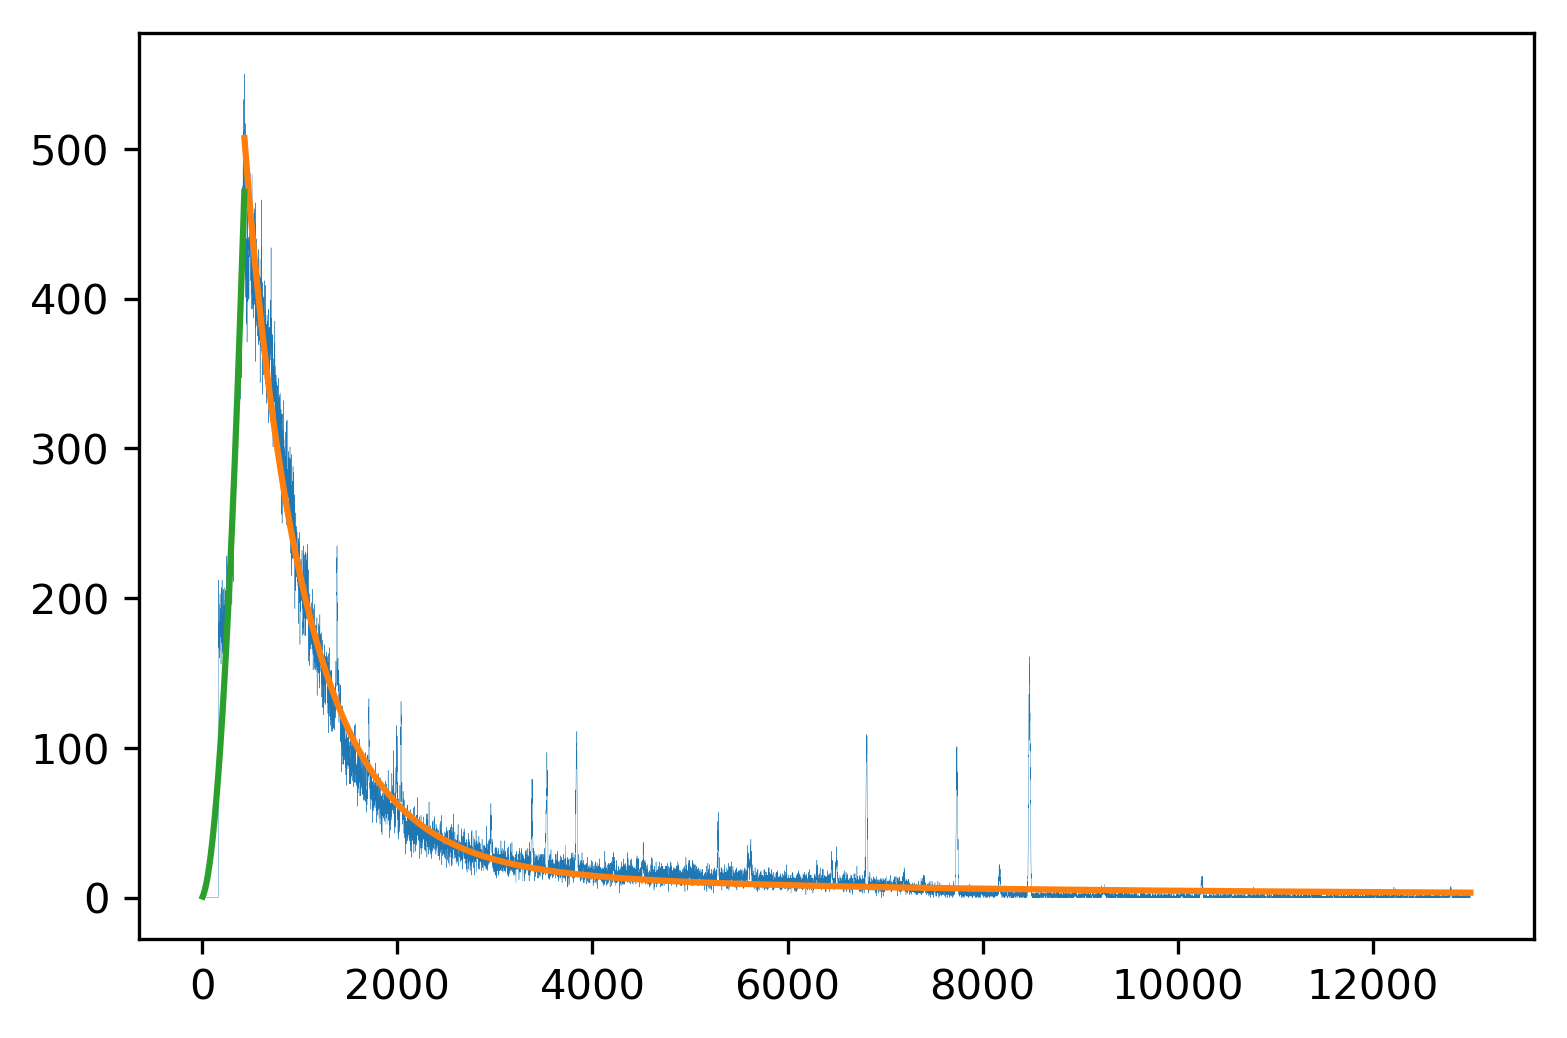

In [151]:
#Correct the background

data=pd.read_table("SS18/Gr 23/hintergrund.TKA",skiprows=2)
values=dataToNpArray(data,0)
fig,ax=plt.subplots(dpi=300)
values=values.astype(float)

#Da sonst der Totzeitkorrekturpeak mit berechnet wird
maxval=13000
argmax=np.argmax(values[:maxval])

ax.plot(range(maxval),values[:maxval],"-",ms=.1,lw=.1)
exp=lambda x,A,c,b,d:c*np.exp(x*A)+b/x+d
x=np.array(range(argmax,maxval))
y=values[argmax:maxval]
#ax.plot(x,exp(x,*popt))
#Fit des Exponentiellen? abfalls nach dem Maximum am anfang
expmodel=lm.Model(exp)
parms=expmodel.make_params(A=-.001,c=500,b=50,d=1)
result=expmodel.fit(values[argmax:maxval],parms,x=np.array(range(argmax,maxval)))
expParms=result.best_values.values()
ax.plot(np.array(range(argmax,maxval)),result.best_fit)

backgroundArgMax=argmax


#Square ist das Linke Model. Quadratischer Anstieg oder so.
square=lm.Model(lambda x,a,m:x**2*a+m*x)
parms2=square.make_params(a=1,m=1)
result=square.fit(list(values[5:argmax]),parms2,x=np.array(range(5,argmax)))
ax.plot(range(5,argmax),result.best_fit)
squareParms=result.best_values.values()
print(squareParms)###

In [152]:
def posOr0(val):
    if(val>0):
        return val
    if (val<0):
        return 0
newSquare=lambda x,a,m:x**2*a+m*x
print(realMessZeitDict)
    
def backGroundFit(data,hintergrundmesszeit,realeMesszeit,quadratfit,expfit,argmax=argmax):
    """Soll den Background fitten. Bekommt dazu daten und haut da die backgroundkorrektur drauf."""
    #Wichtig: Keine Negativen einträge
    correctedData=[]
    for i in range(1,argmax):
        appender=posOr0(data[i]-newSquare(i,*quadratfit)*(realeMesszeit/hintergrundmesszeit))
        correctedData.append(appender)
    for i in range(argmax,len(data)):
        correctedData.append(posOr0(data[i]-exp(i,*expfit)*(realeMesszeit/hintergrundmesszeit)))
    return correctedData

{'hintergrund': 3589.9714259094308, 'Na22': 895.9684247335997, 'Totzeit': 297.683536163031, 'unbekannt': 895.9641129337331, 'Eu152': 848.1726806023997, 'Cs137': 866.7875886279651, 'Co60': 891.4338561882028, 'Ba133': 865.8050845801084, 'Aufgabe5': 818.4784096126245, 'Am241': 869.511220568883}


Hier müssen wir dann die Daten irgendwie anpassen mit der wunderschönen Funktion die wir geschrieben haben

In [153]:
correctedDataDict={}
for name in datadict:
    correctedDataDict.update({name:np.array( backGroundFit(datadict[name],realMessZeitDict["hintergrund"],realMessZeitDict[name], squareParms, expParms, argmax=backgroundArgMax))})
    #fig,ax=plt.subplots(figsize=(20,5))
    #ax.plot(correctedDataDict[name],"-",lw=.3)
    #ax.set_title(name)
    #ax.set_ylim(0,1000)
    #ax.semilogy()
    #print(max(-correctedDataDict[name]))

## Jetzt alle Messungen einzeln maxvals aussuchen und diese dann Fitten (Automatisch)
## Danach mit Findpeaks einzelne bereiche absuchen

In [154]:
print(correctedDataDict.keys())
#einfach ignorieren
m=1


dict_keys(['hintergrund', 'Na22', 'Totzeit', 'unbekannt', 'Eu152', 'Cs137', 'Co60', 'Ba133', 'Aufgabe5', 'Am241'])


## Fitpeaks Funktion

In [155]:

def xInEnergy(x):
    x=np.array(x)
    x=m*x
    return(x)
def mixValsErrors(vals,errors):
    retlist=[]
    for i in range(len(vals)):
        retlist.append(vals[i])
        retlist.append(errors[i])
    retlist=np.array(retlist).astype(float)
    return(retlist)
    
def fitpeaks(name,maxval,totalax,width=25,lower=0,upper=-1,totalaxlimit=max(correctedDataDict[name])+100,lookformore=0,plotAgain=True,colorcounter=1,keV=True,peakcounter=1):
    peakcounter=peakcounter
    gmodel=lm.Model(Gaus)
    print(gmodel.param_names)
    data=correctedDataDict[name]
    peakList=[]
    peakErrorList=[]
    totalax.set_ylim(0,totalaxlimit)
    if(upper==-1):
        upper=len(data)
        if(plotAgain):
            totalax.plot(xInEnergy(np.array(range(len(data)))),data)

    grenzen=findpeaks(data[lower:upper],maxval,width,lower=lower,lookformore=lookformore)
    for x,y in grenzen:
        xdata=np.array(range(x,y))
        fig,ax=plt.subplots(dpi=144)
        ax.plot(xInEnergy(xdata),data[x:y],".")
        params=gmodel.make_params(mu=(x+y)/2,sigma=1,A=2,b=0)
        result=gmodel.fit(data[x:y],params,x=xdata,weights=(np.sqrt(data[x:y]))/zeroTo1(data[x:y]))
        redchi=result.redchi
        try:
            errors=np.sqrt(np.diag(result.covar)).astype(float)
        except:
            errors=[]
            for x in result.best_values.values():
                errors.append(0)
        peakErrorList.append(errors[0])
        bestVals=list(result.best_values.values())
        musigma=list(xInEnergy(bestVals[:2]))
        Ab=list(bestVals[2:])
        dAdb=list(errors[2:])
        dmudsigma=list(xInEnergy(errors[:2]))
        vals=musigma+Ab
        errors=dAdb+dmudsigma
        
        label=mixValsErrors(vals,errors)
        ax.set_title("Peak {}".format(peakcounter))
        if(keV):
            ax.plot(xInEnergy(xdata),result.best_fit,c="C{}".format(colorcounter),label="$\mu$: {:.2e}$\pm${:.2e}keV \n$\sigma$: {:.2e}$\pm${:.2e}keV\nA: {:.2e}$\pm${:.2e} \nb:{:.2e}$\pm${:.2e} \n $\chi^2$: {:.2f} ".format(*label,redchi))
            ax.legend(loc="best")
            totalax.plot(xInEnergy(xdata),result.best_fit,c="C{}".format(colorcounter),label="Peak {} $\mu$: {:.4e}keV ".format(peakcounter,xInEnergy(list(result.best_values.values())[0])))
        if(not keV):
            ax.plot(xInEnergy(xdata),result.best_fit,c="C{}".format(colorcounter),label="$\mu$: {:.2e}$\pm${:.2e} \n$\sigma$: {:.2e}$\pm${:.2e}\nA: {:.2e}$\pm${:.2e} \nb:{:.2e}$\pm${:.2e} \n $\chi^2$: {:.2f} ".format(*label,redchi))
            ax.legend(loc="best")
            totalax.plot(xInEnergy(xdata),result.best_fit,c="C{}".format(colorcounter),label="Peak {} $\mu$: {:.4e} ".format(peakcounter,list(result.best_values.values())[0]))
        colorcounter=colorcounter+1
        peakcounter=peakcounter+1
        if(colorcounter==9):
            colorcounter=0
        peakList.append(list(result.best_values.values())[0])
    peakErrorList=np.array(peakErrorList).astype(float)
    return (grenzen,colorcounter,peakList,peakErrorList)


## Aufgabe 5

['mu', 'sigma', 'A', 'b']
['mu', 'sigma', 'A', 'b']


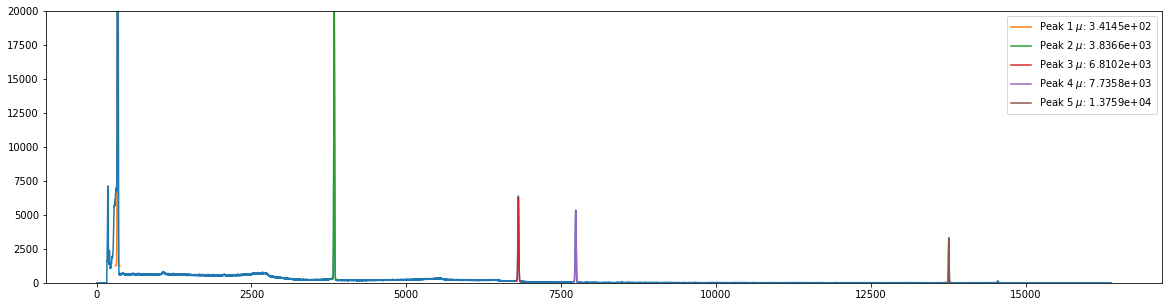

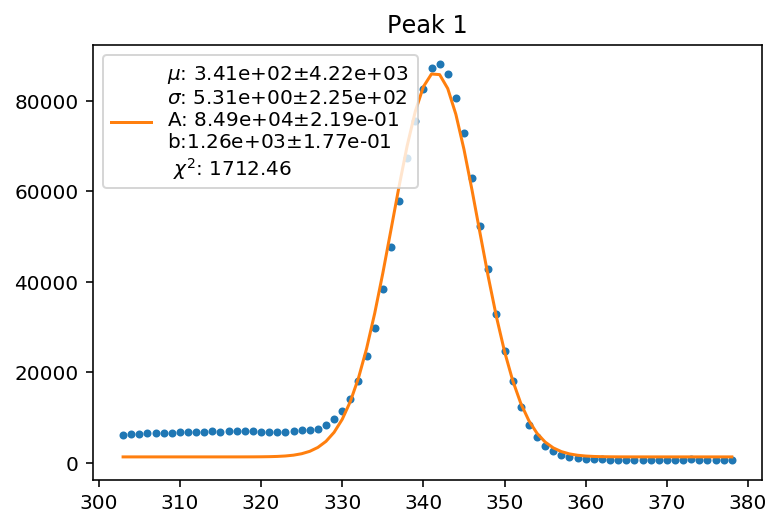

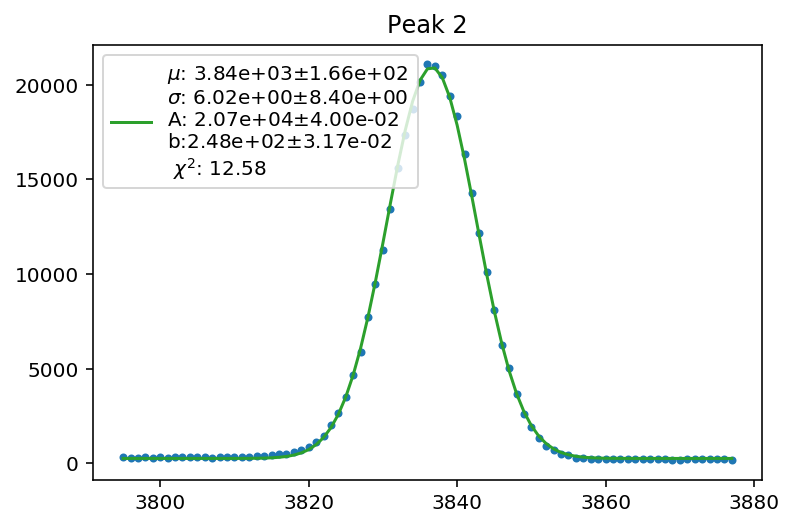

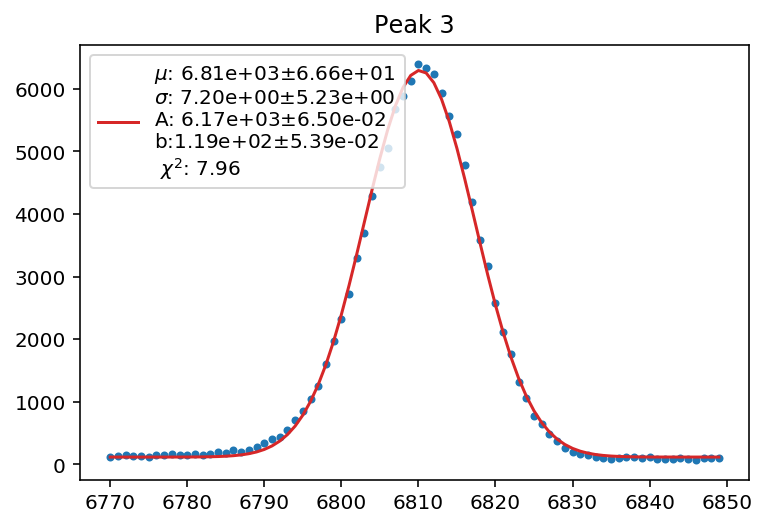

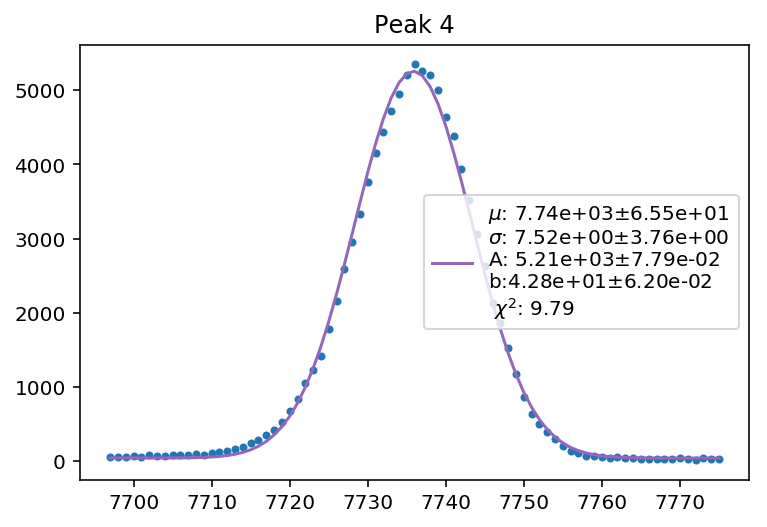

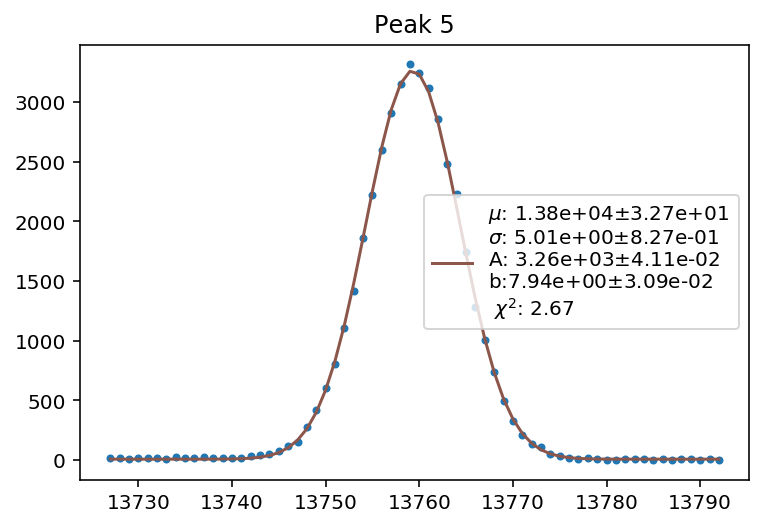

In [156]:
name="Aufgabe5"
totalfig,totalax=plt.subplots(figsize=(20,5))
a,c,peaks1,errors1=fitpeaks(name,8000,totalax,lower=200,upper=1000,totalaxlimit=1000,lookformore=0,colorcounter=1,keV=False)
b,c,peaks2,errors2=fitpeaks(name,850,totalax,lower=400,totalaxlimit=20000,lookformore=1,colorcounter=2,peakcounter=2,keV=False)
#b,c,peaks2,errors2=fitpeaks(name,1000,totalax,lower=1,totalaxlimit=1000,lookformore=1,colorcounter=1,keV=False)
totalax.legend()
#totalax.semilogy()


## Energiekalibrierung

[  341.45377146  3836.5834647   6810.16714631  7735.84931965
 13759.3193682 ]
None
[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 5
    # variables        = 3
    chi-square         = 27.3814569
    reduced chi-square = 13.6907285
    Akaike info crit   = 14.5021406
    Bayesian info crit = 13.3304543
[[Variables]]
    m:  0.20849787 +/- 0.01396974 (6.70%) (init = 10)
    a: -5.5738e-06 +/- 1.2906e-06 (23.15%) (init = 0)
    b: -12.4628111 +/- 18.7885371 (150.76%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, a) = -0.946
    C(m, b) = -0.510
    C(a, b) =  0.375

<class 'numpy.float64'>
6.296572357817271


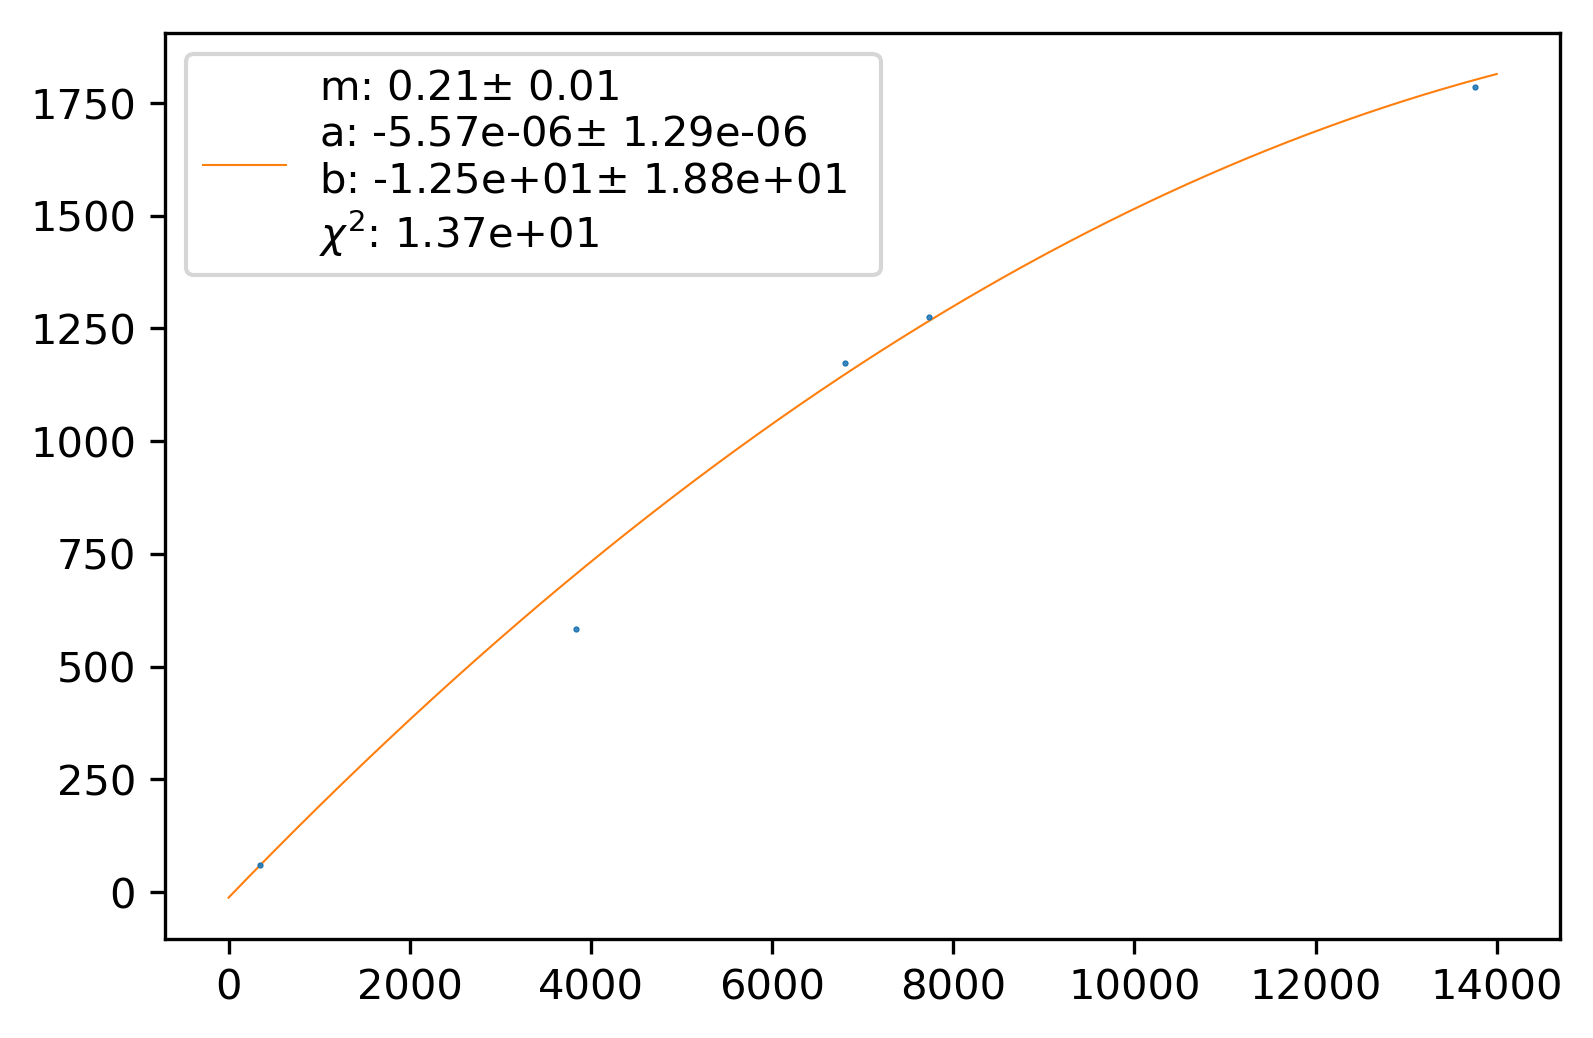

In [157]:
peaks=[]
errors=[]
peaks.extend(peaks1)
peaks.extend(peaks2)
peaks=np.array(peaks)

errors.extend(errors1)
errors.extend(errors2)
print(print(peaks))
energies=[59.5409,583.03,1173.2,1275,1786]
fig,ax=plt.subplots(dpi=300)
ax.errorbar(peaks,energies,fmt=".",yerr=np.array(errors),ms=1,lw=0.3)
lin=lambda x,m,a,b: m*x+a*x**2+b
linearModel=lm.Model(lin)
parms=linearModel.make_params(m=10,a=0,b=0)
result=linearModel.fit(energies,parms,x=peaks,weights=errors)
print(result.fit_report())
popt=getValues(result)
perr=getErrors(result)
print(type(popt[0]))
mylin=np.linspace(0,14000,10000)
ax.plot(mylin,lin(mylin,*popt),lw=0.5,label="m: {:.2f}$\pm$ {:.2f} \na: {:.2e}$\pm$ {:.2e}\nb: {:.2e}$\pm$ {:.2e}  \n$\chi^2$: {:.2e}".format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2],result.redchi))
ax.legend()
print(6.296572357817271)

In [189]:
m=popt[0]
a=float(popt[1])
b=popt[2]

print(a*2)
dm=perr[0]/popt[0]**2
print(m)

def xInEnergy(x):
    x=np.array(x).astype(float)
    x=x*m+np.square(x)*(-4.878507623893381e-06)-b
    return(x)

-1.1147635995116858e-05
0.20849787050098184


## Hintergrund

['mu', 'sigma', 'A', 'b']


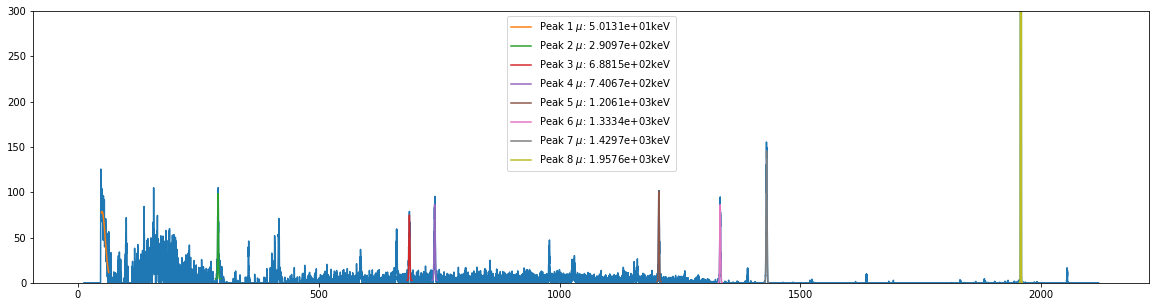

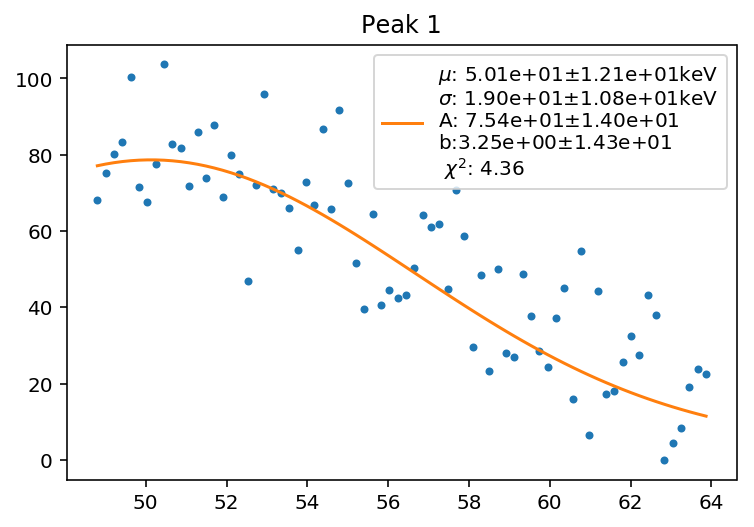

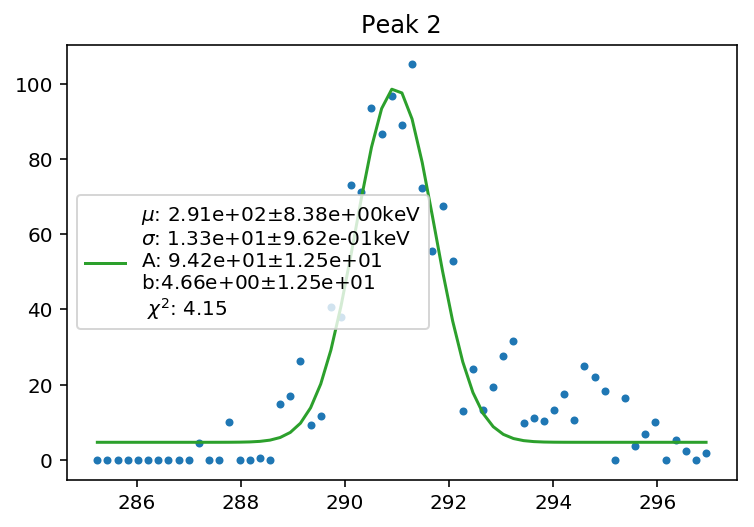

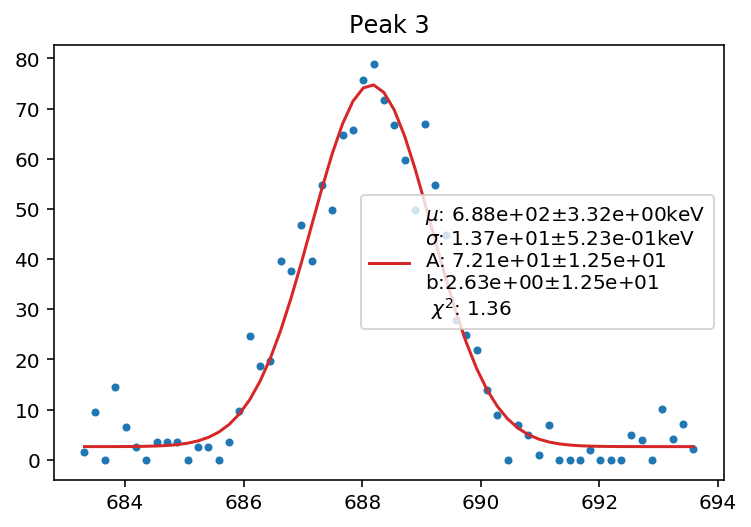

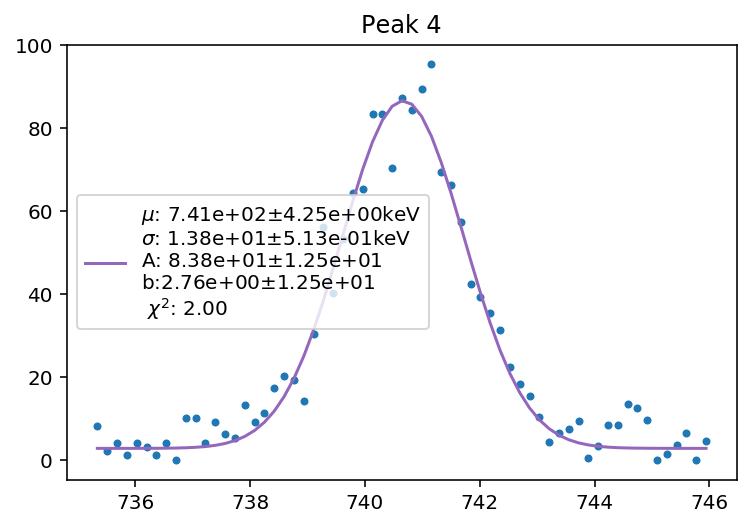

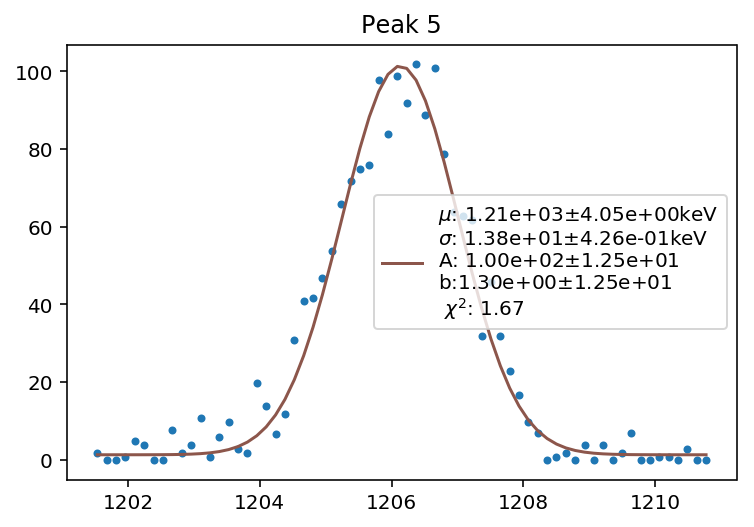

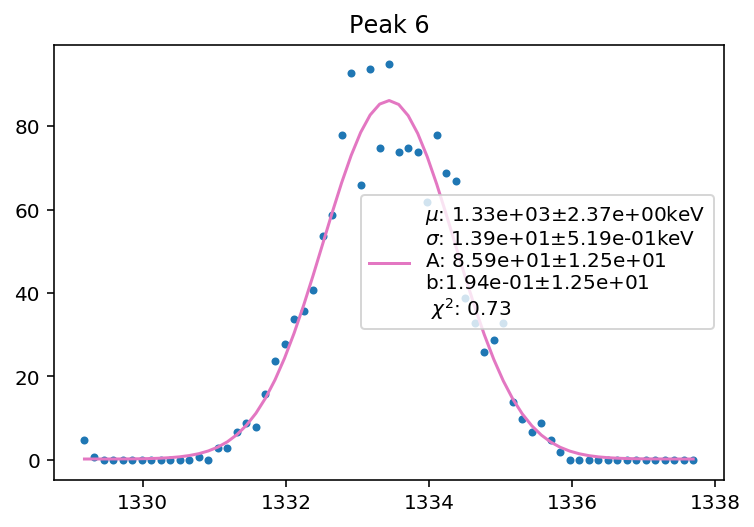

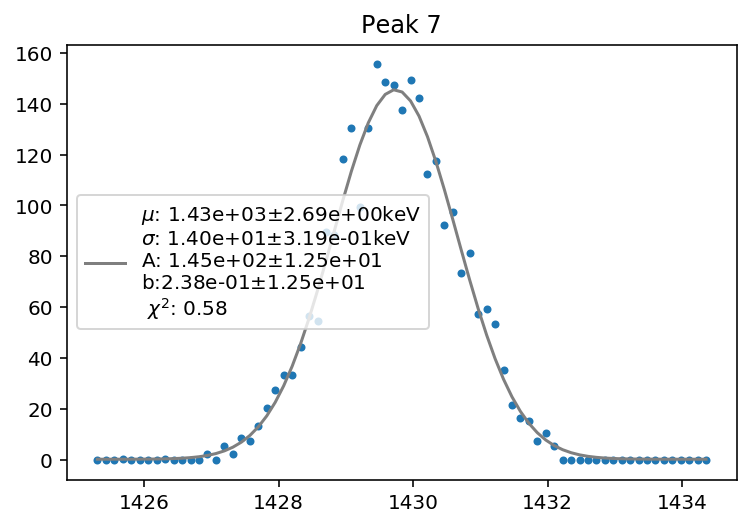

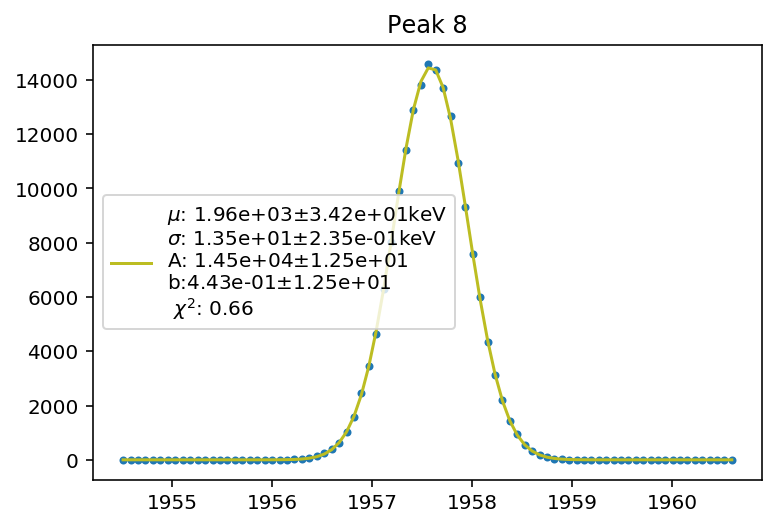

In [169]:
name="hintergrund"
totalfig,totalax=plt.subplots(figsize=(20,5))
a,c,peaks1,errors1=fitpeaks(name,50,totalax,lower=200,totalaxlimit=300,lookformore=6,colorcounter=1,keV=True)

totalax.legend()
#totalax.semilogy()

## Na22

['mu', 'sigma', 'A', 'b']


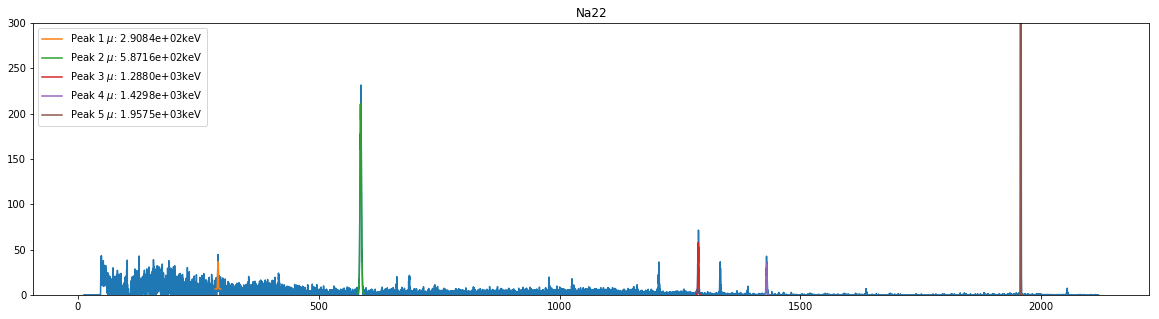

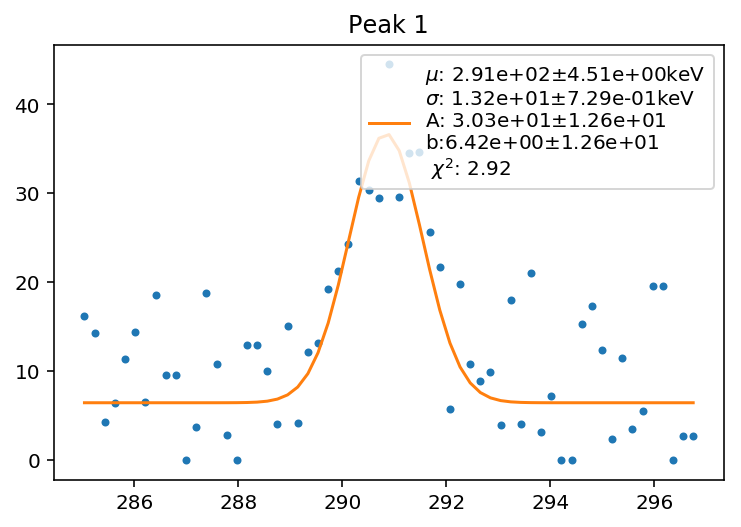

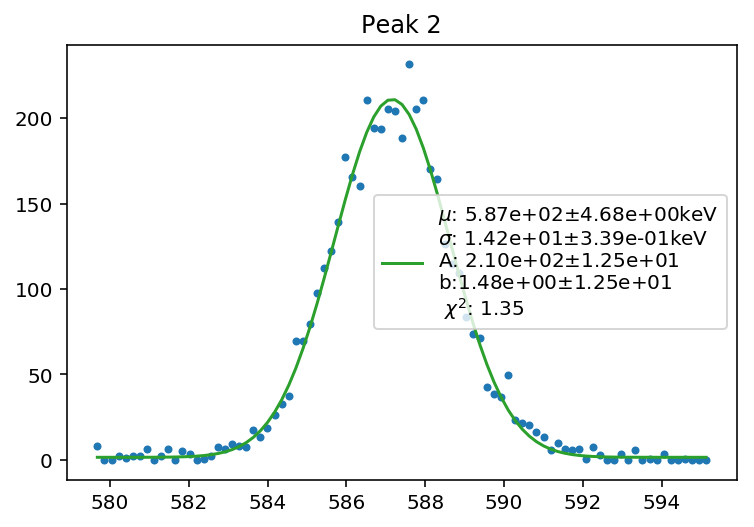

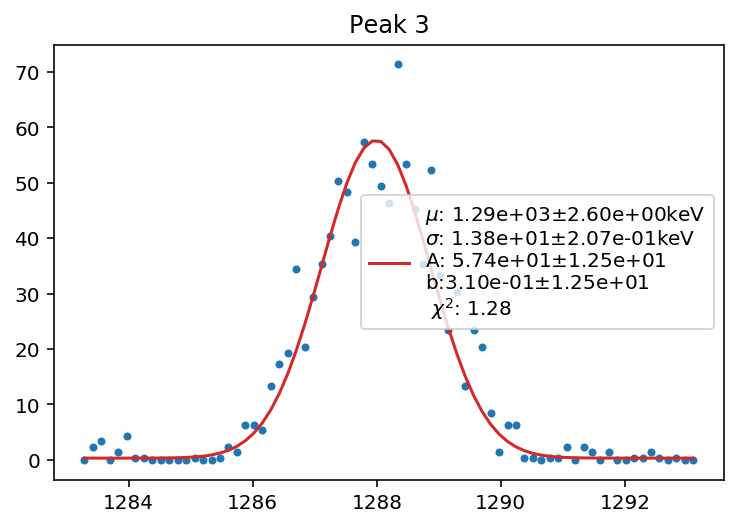

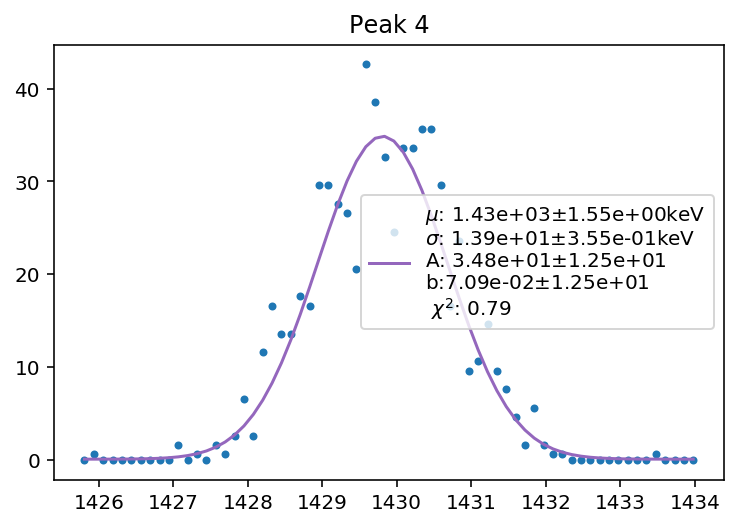

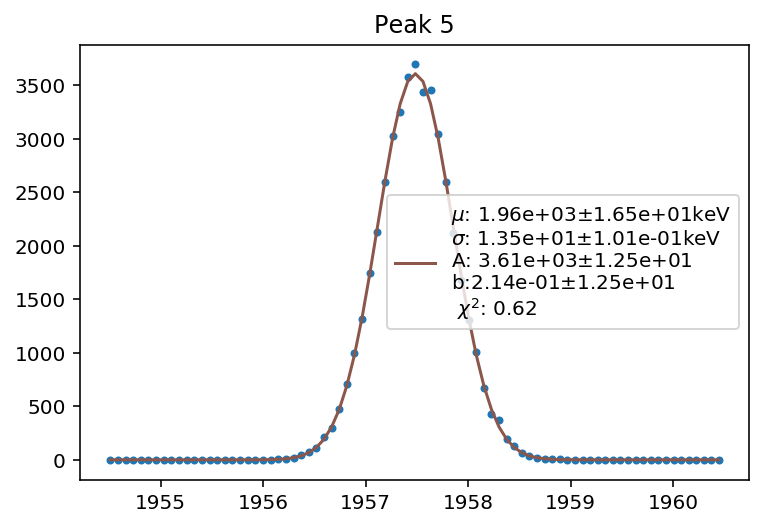

In [170]:
name="Na22"
totalfig,totalax=plt.subplots(figsize=(20,5))
a,c,peaks1,errors1=fitpeaks(name,20,totalax,lower=200,totalaxlimit=300,lookformore=6,colorcounter=1,keV=True)
totalax.set_title(name)
totalax.legend()
#totalax.semilogy()

## Co60

['mu', 'sigma', 'A', 'b']


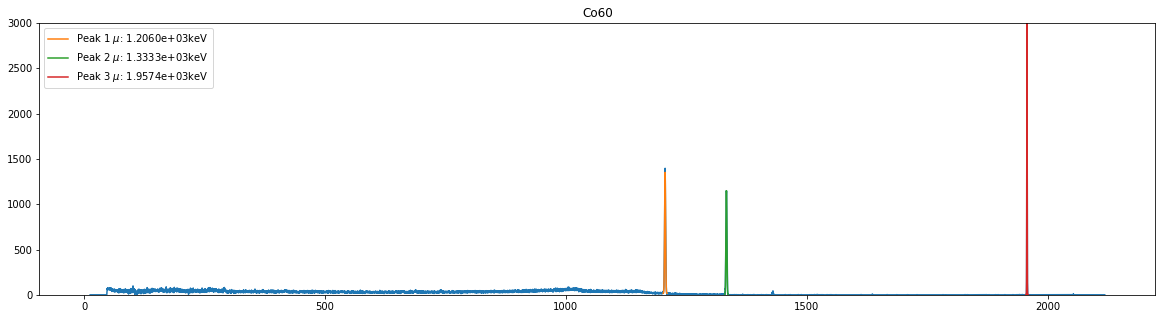

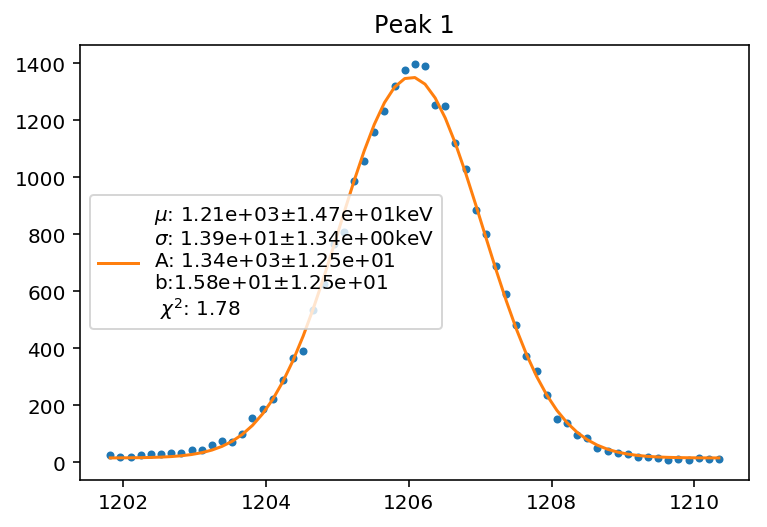

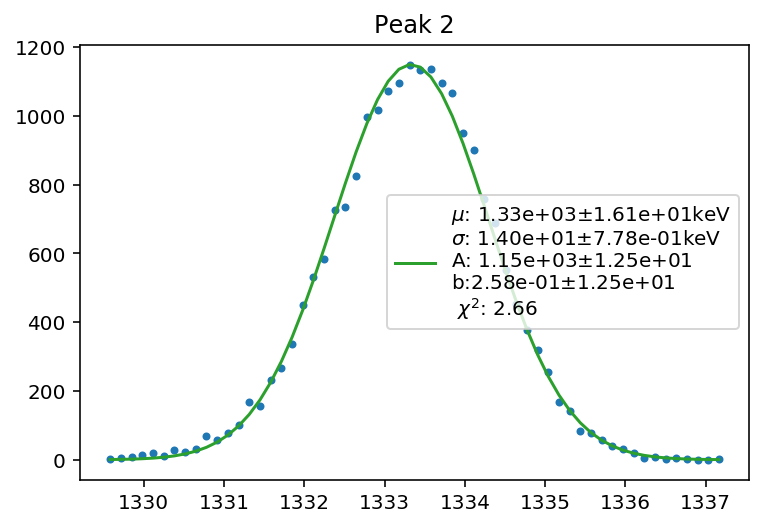

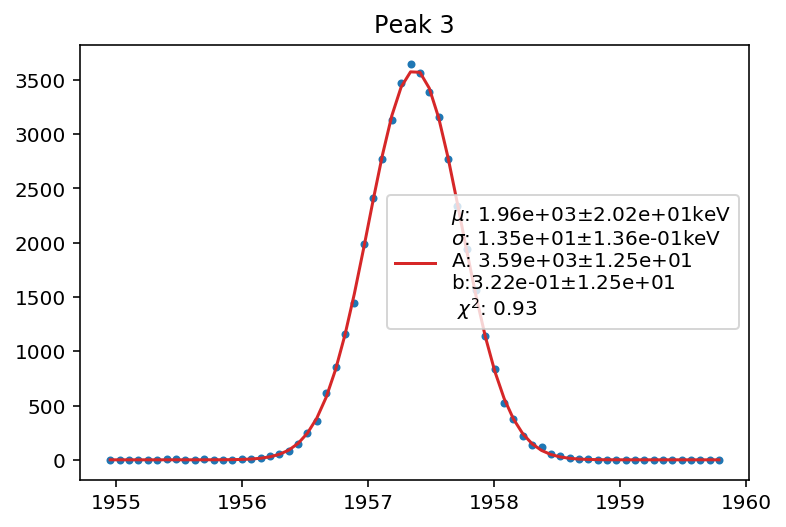

In [171]:
name="Co60"
totalfig,totalax=plt.subplots(figsize=(20,5))
a,c,peaks1,errors1=fitpeaks(name,1000,totalax,lower=200,totalaxlimit=3000,lookformore=6,colorcounter=1,keV=True)
totalax.set_title(name)
totalax.legend()
#totalax.semilogy()

## unbekannt

['mu', 'sigma', 'A', 'b']


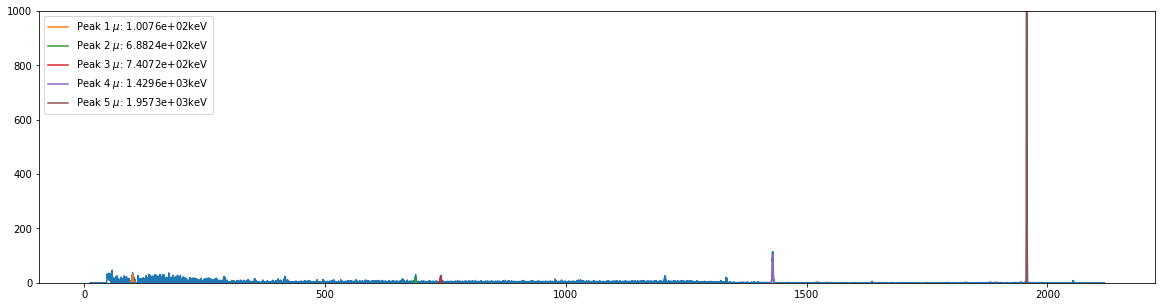

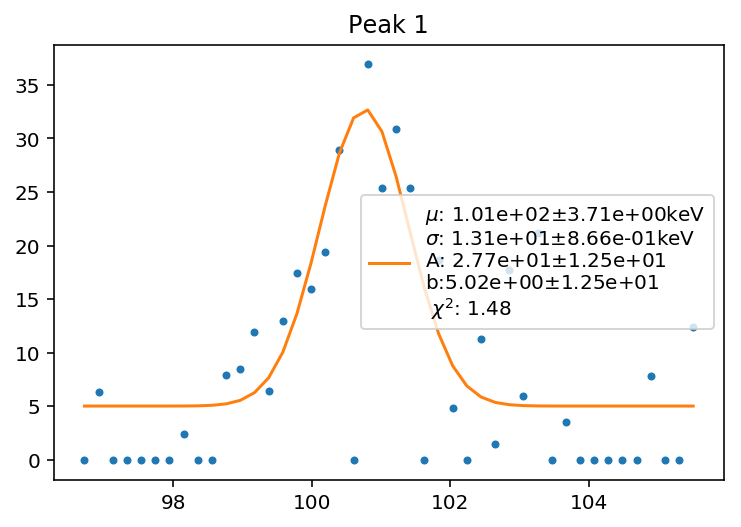

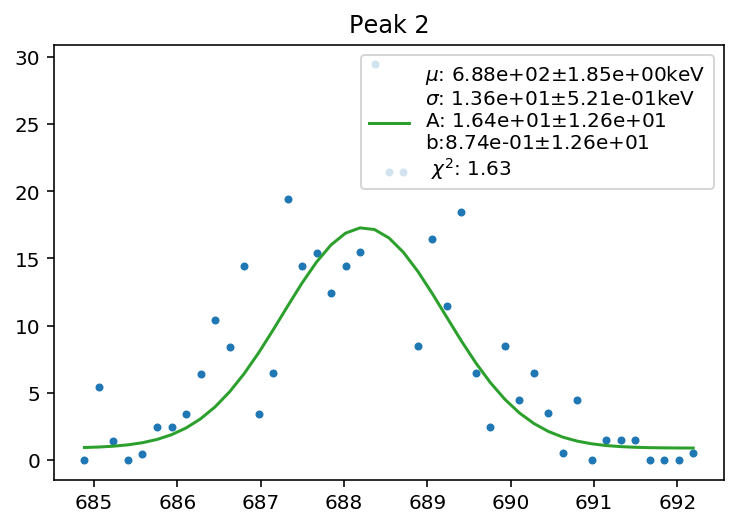

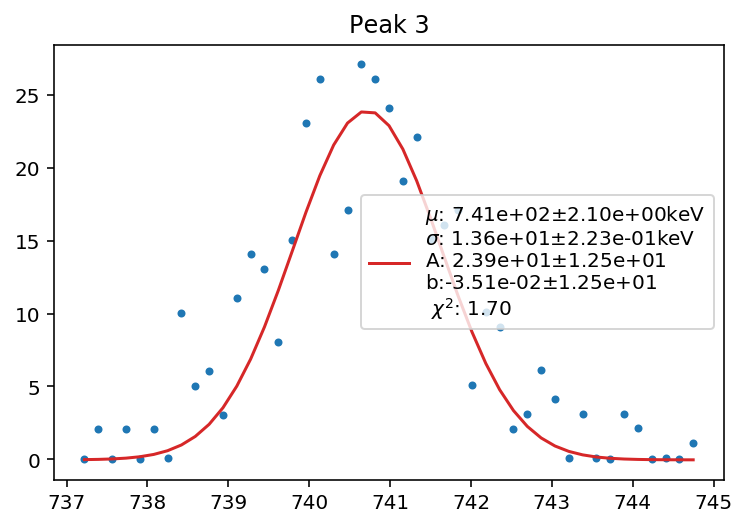

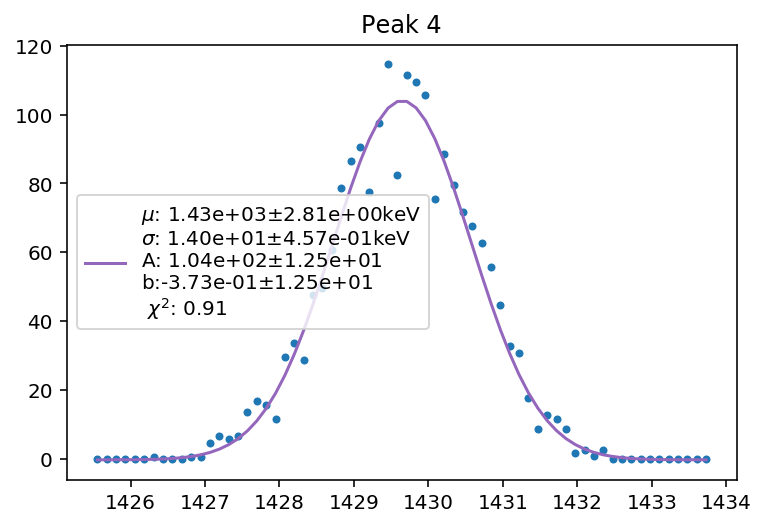

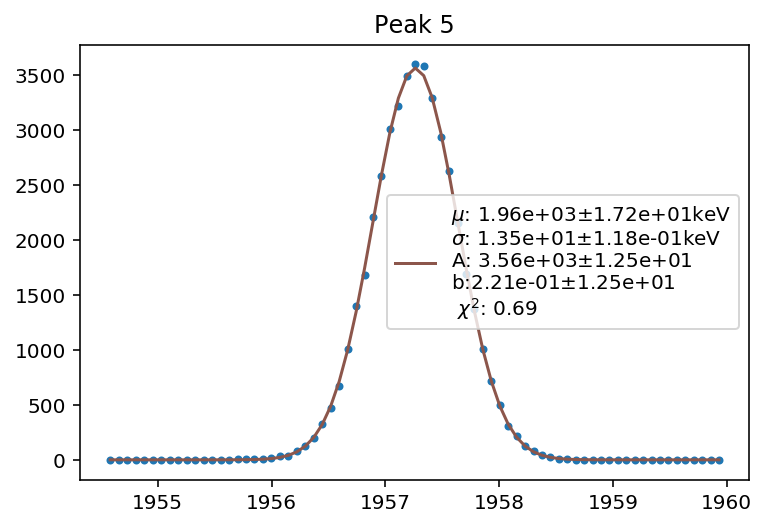

In [172]:
name="unbekannt"

totalfig,totalax=plt.subplots(figsize=(20,5))
a,c,peaks1,errors1=fitpeaks(name,20,totalax,lower=300,width=20,totalaxlimit=1000,lookformore=3,colorcounter=1)
totalax.legend()

## Am241

## Cs137

['mu', 'sigma', 'A', 'b']
[183.08317140160915, 208.63571443136473, 3836.7445504165144, 13754.946505313432]


Text(0.5,1,'Cs137')

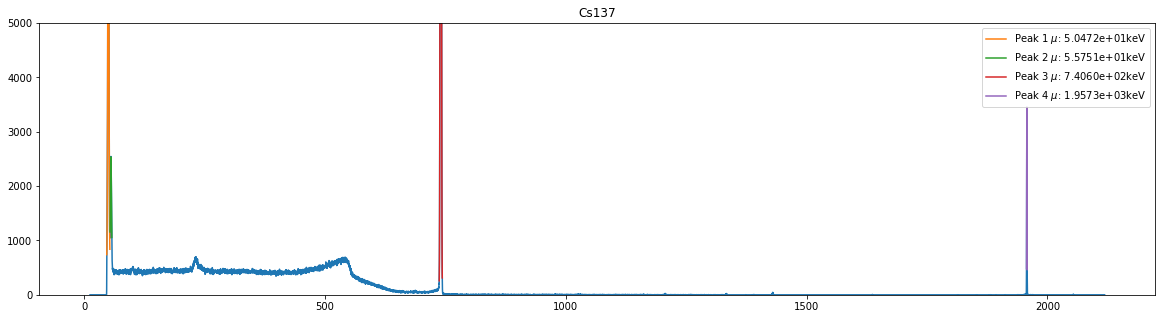

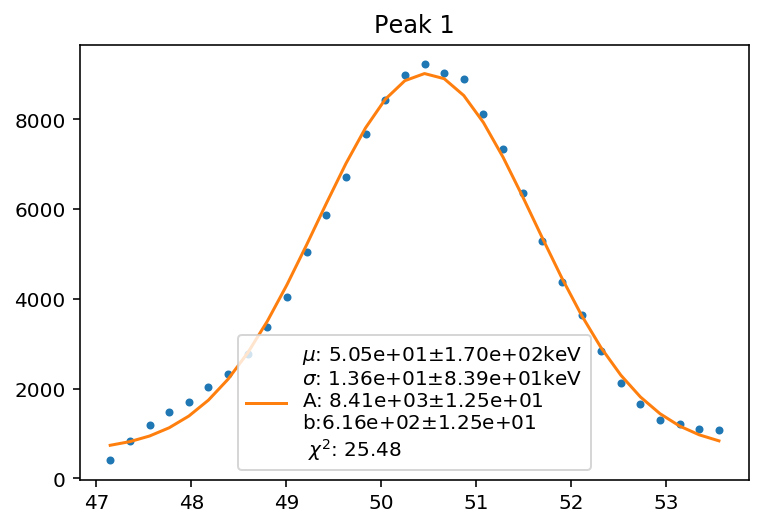

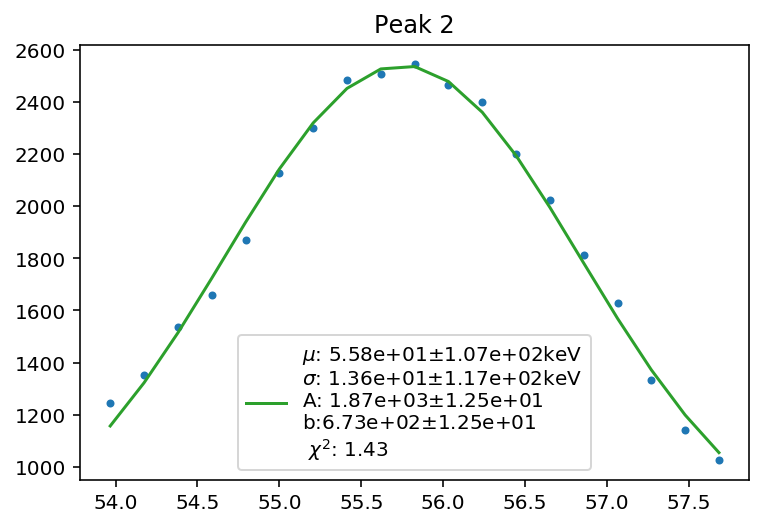

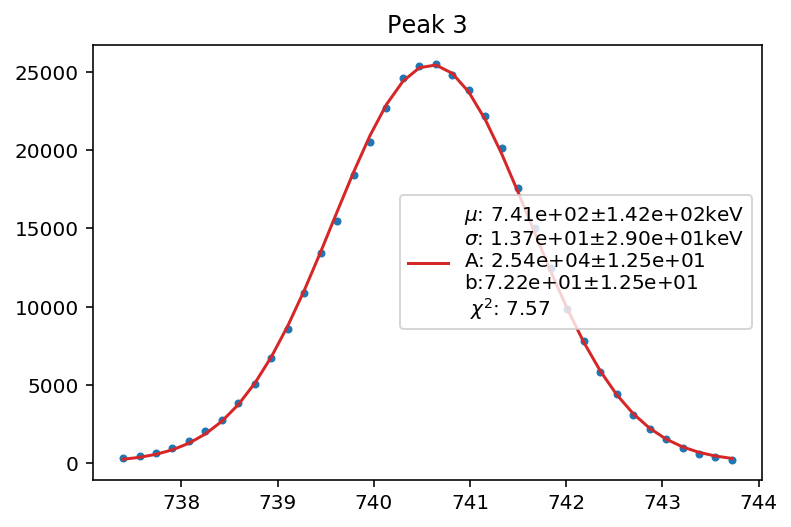

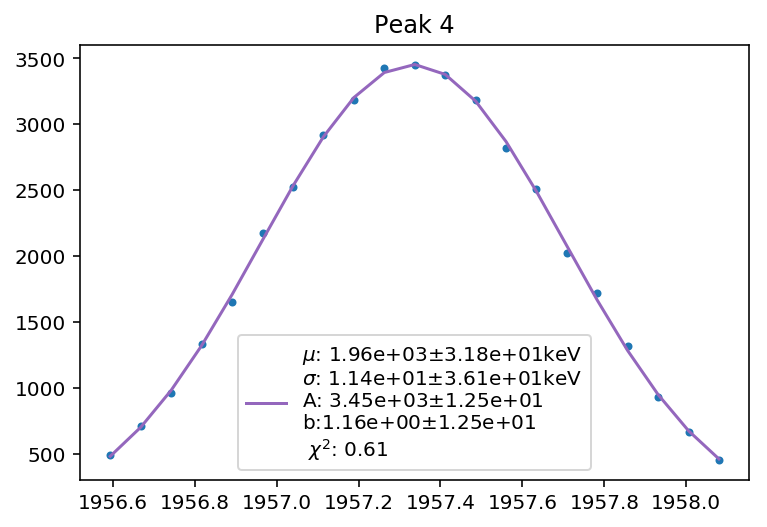

In [173]:
name="Cs137"

totalfig,totalax=plt.subplots(figsize=(20,5))
a,c,peaks1,errors1=fitpeaks(name,2000,totalax,lower=0,width=5,totalaxlimit=5000,lookformore=5,colorcounter=1)
#a,c,peaks1,errors1=fitpeaks(name,600,totalax,lower=2200,upper=3000,width=5,totalaxlimit=5000,lookformore=5,colorcounter=c,peakcounter=c)
print(peaks1)
totalax.legend()
totalax.set_title(name)

## Ba133

['mu', 'sigma', 'A', 'b']


Text(0.5,1,'Ba133')

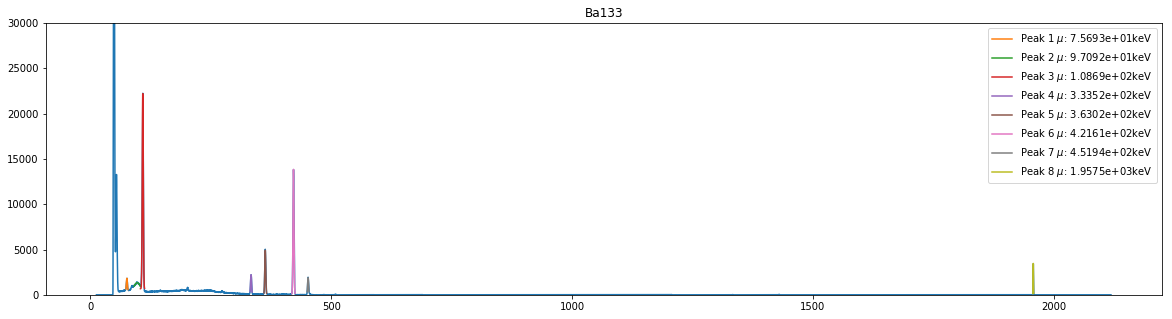

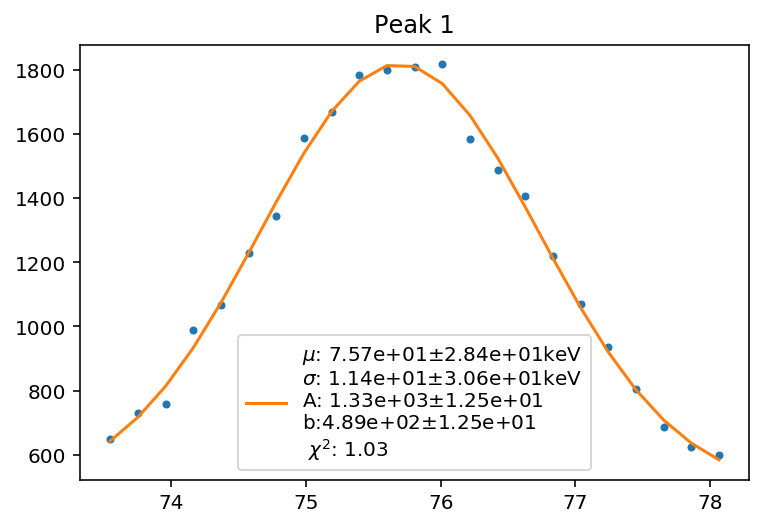

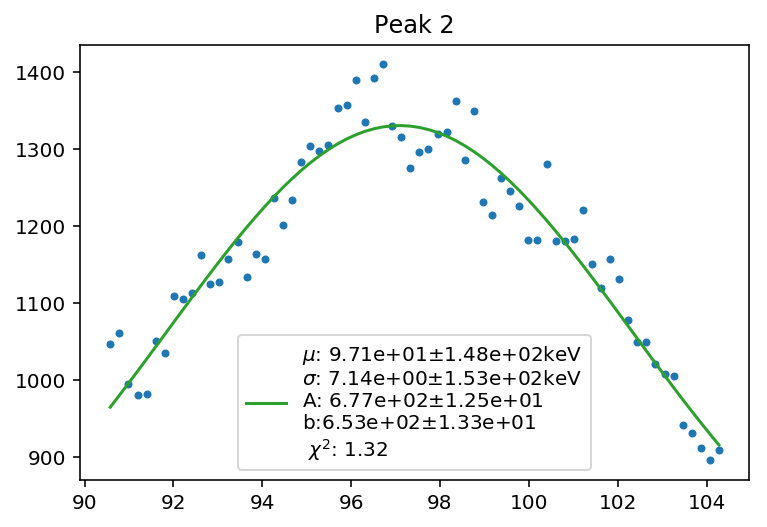

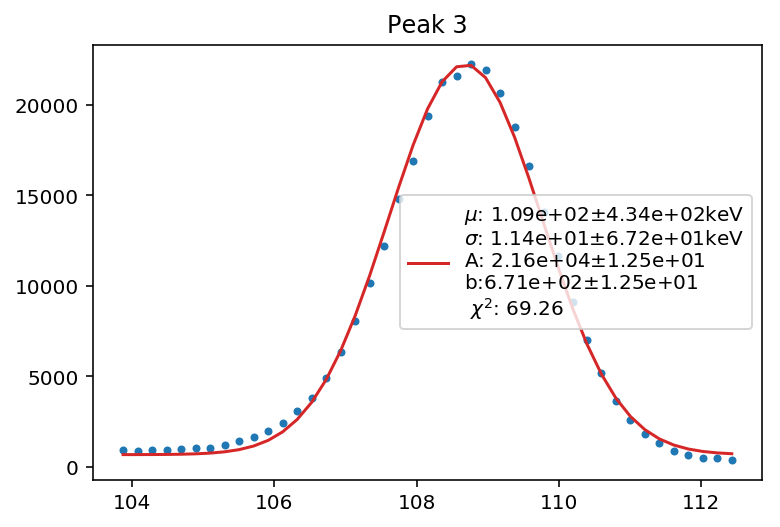

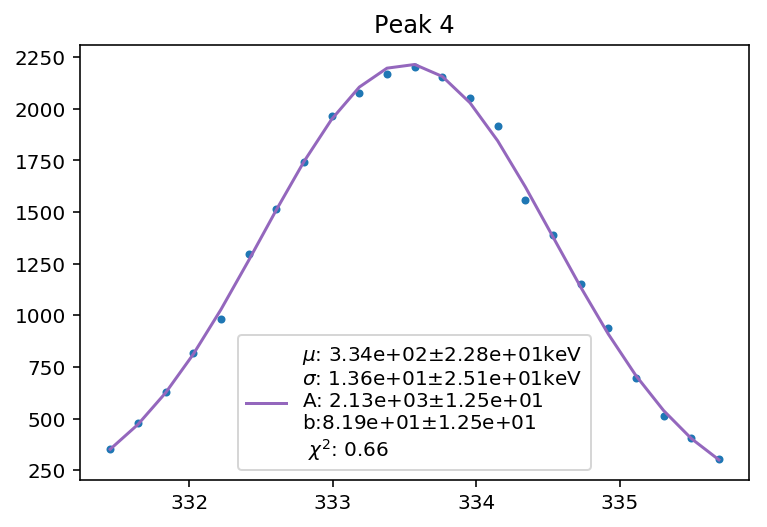

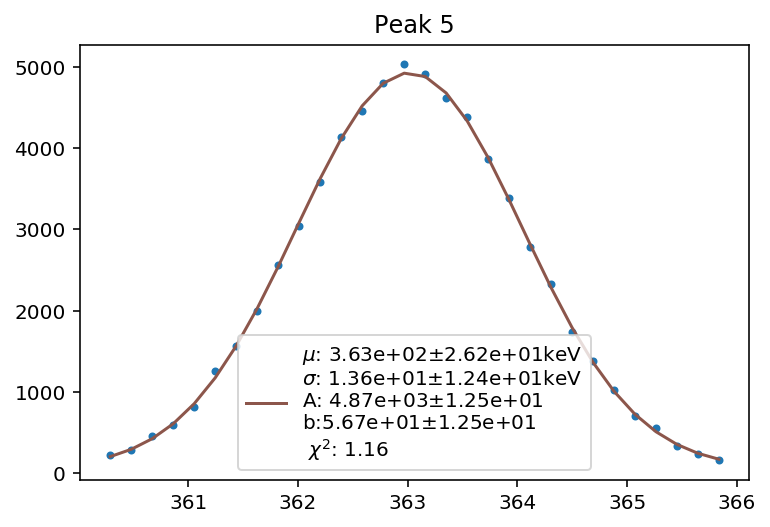

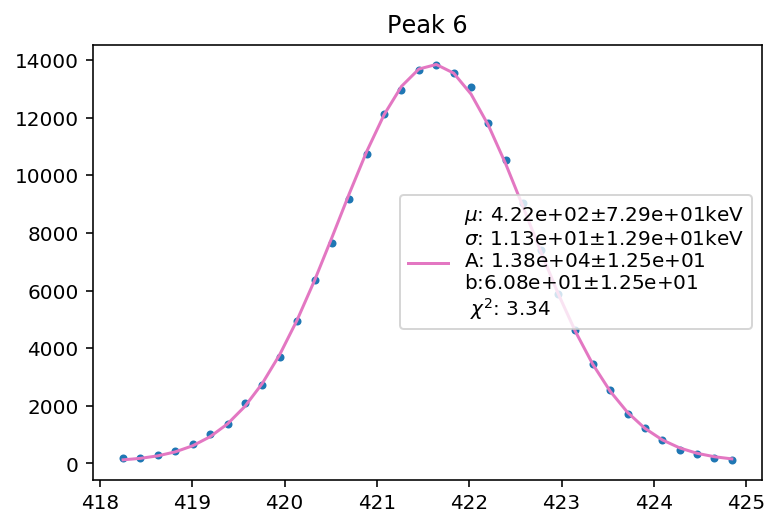

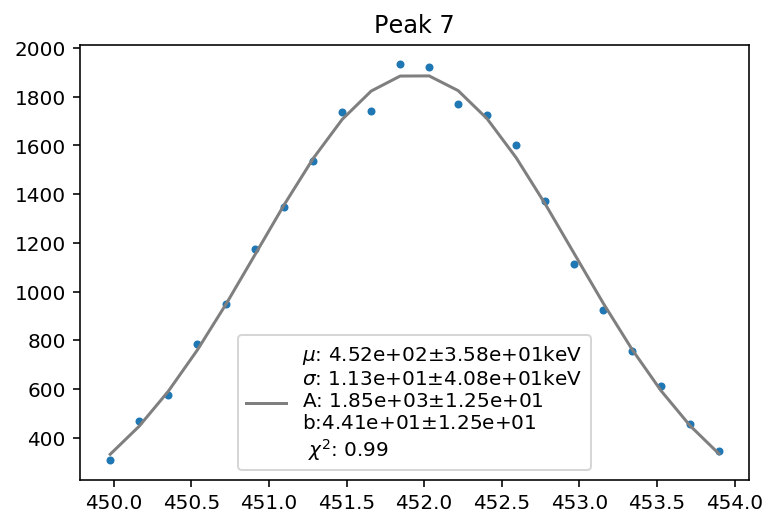

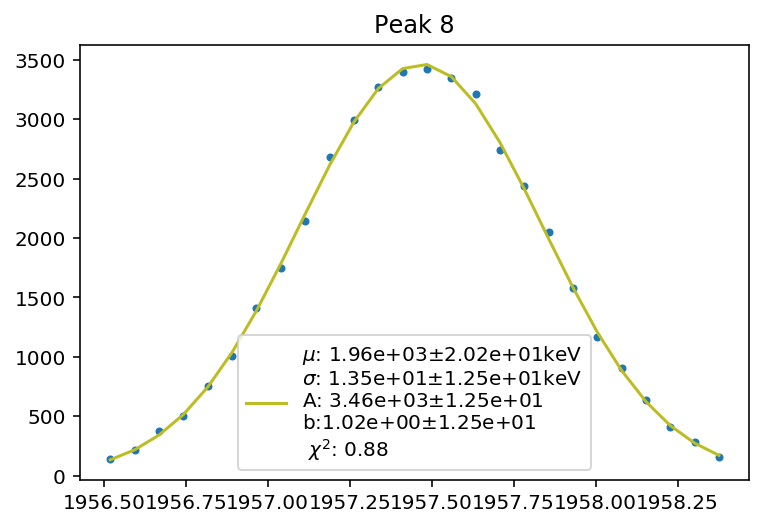

In [181]:
name="Ba133"

totalfig,totalax=plt.subplots(figsize=(20,5))
a,c,peaks1,errors1=fitpeaks(name,1000,totalax,lower=300,width=5,totalaxlimit=30000,lookformore=5,colorcounter=1)
totalax.legend()
totalax.set_title(name)

## Eu152

['mu', 'sigma', 'A', 'b']


Text(0.5,1,'Eu152')

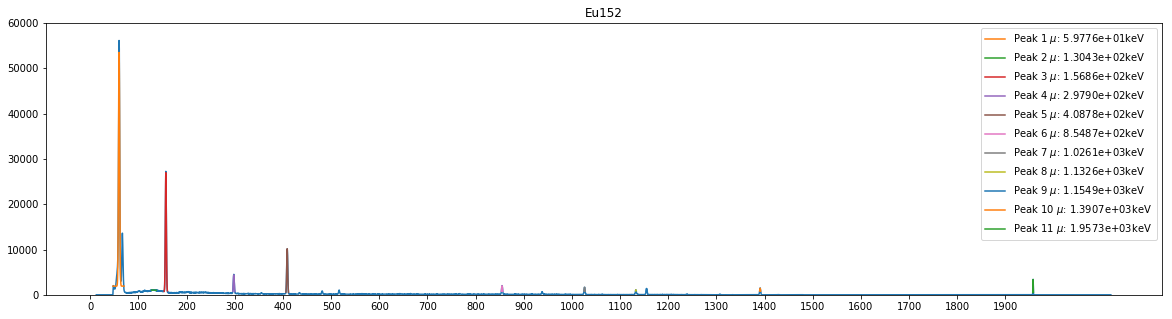

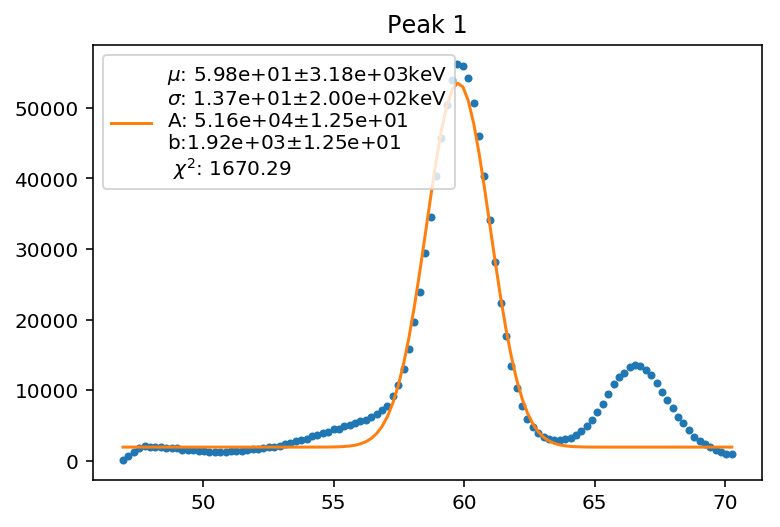

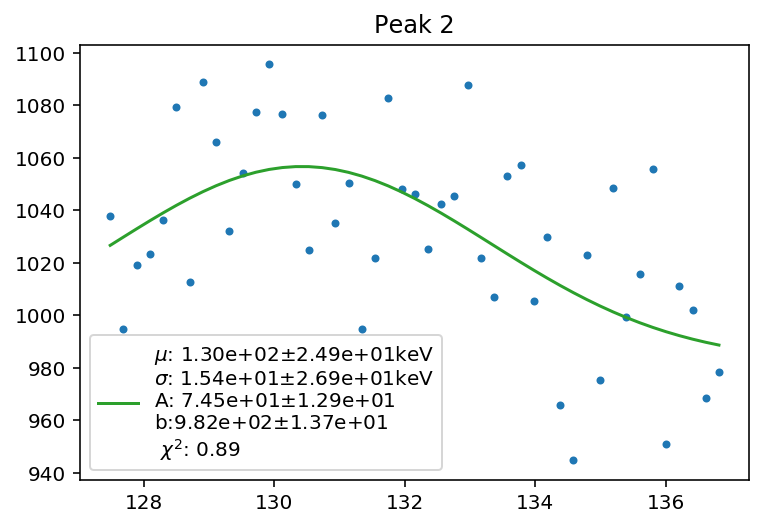

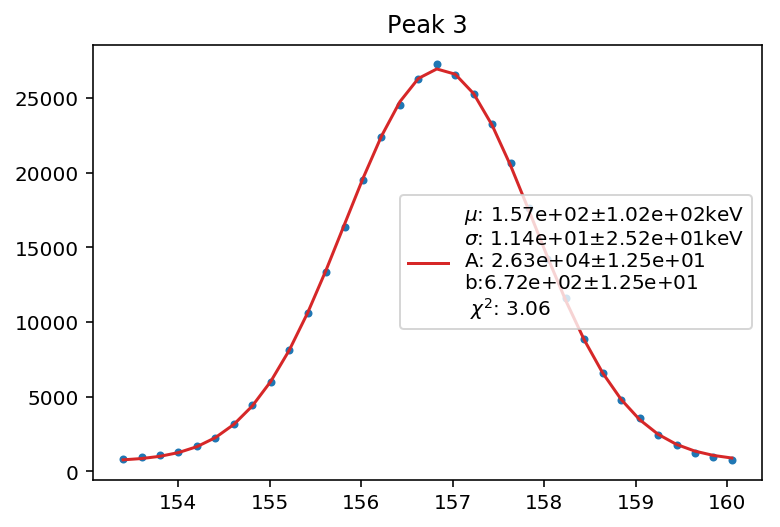

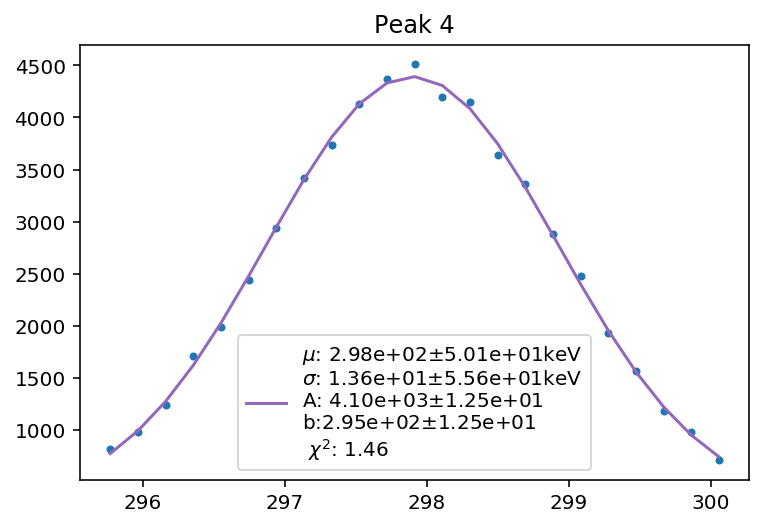

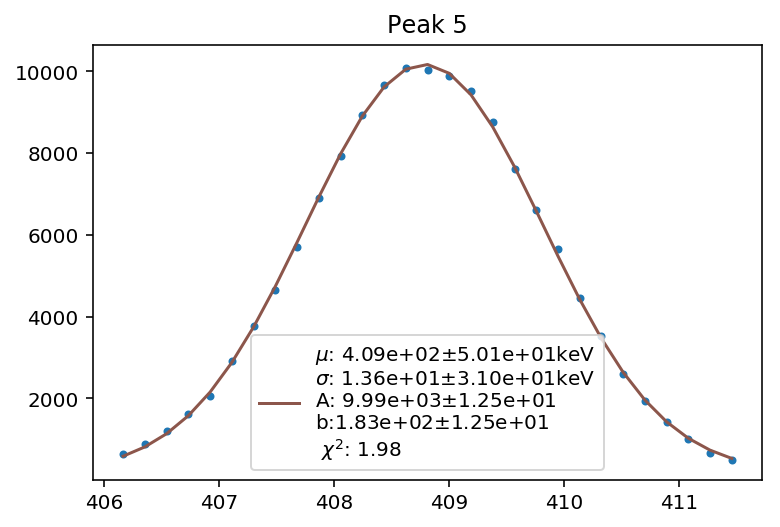

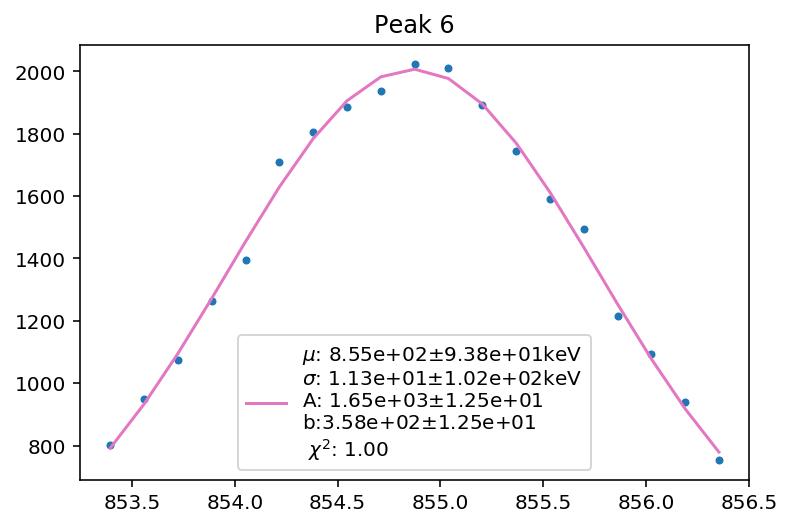

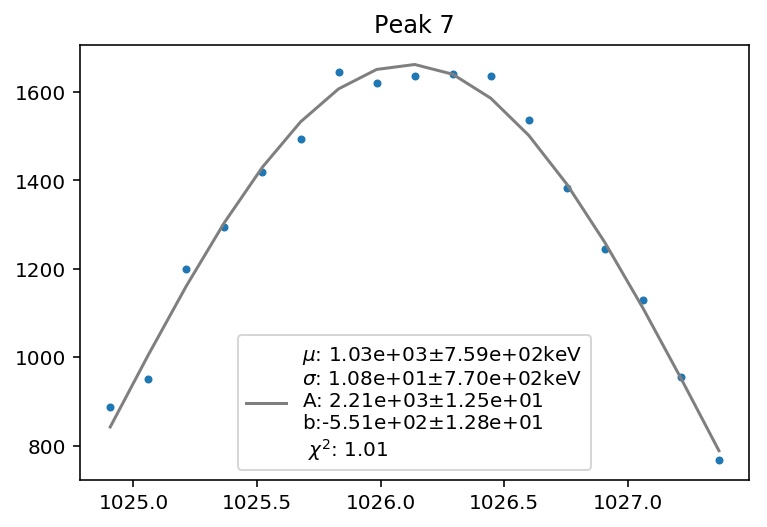

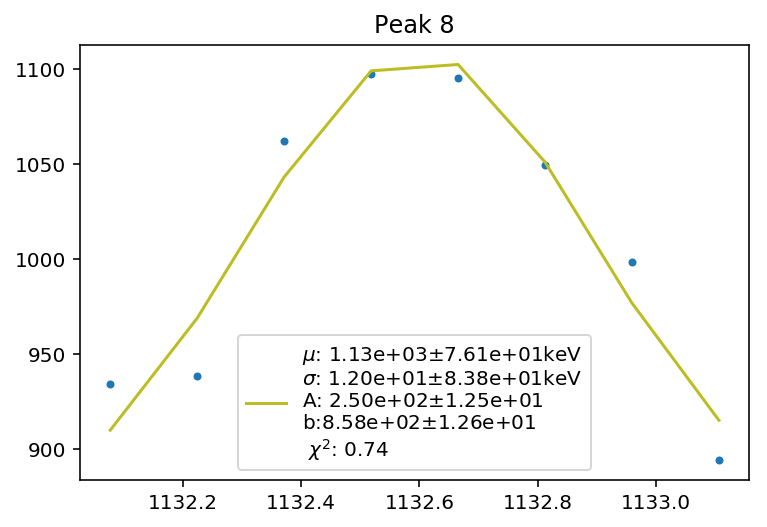

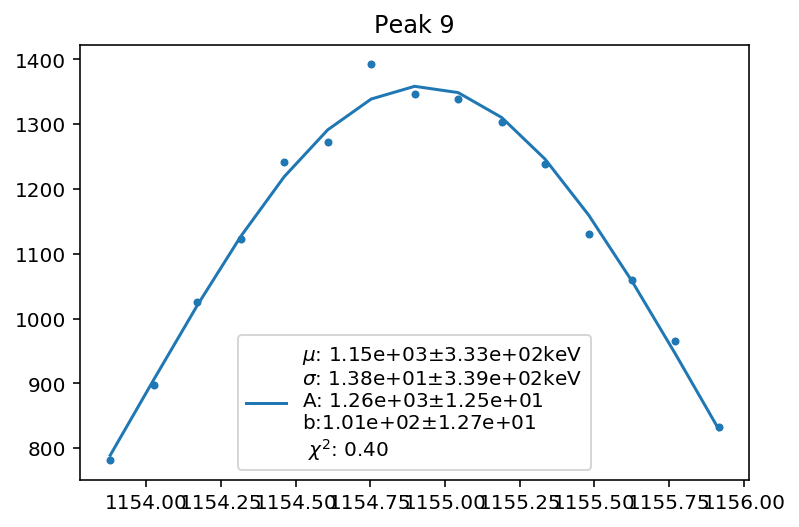

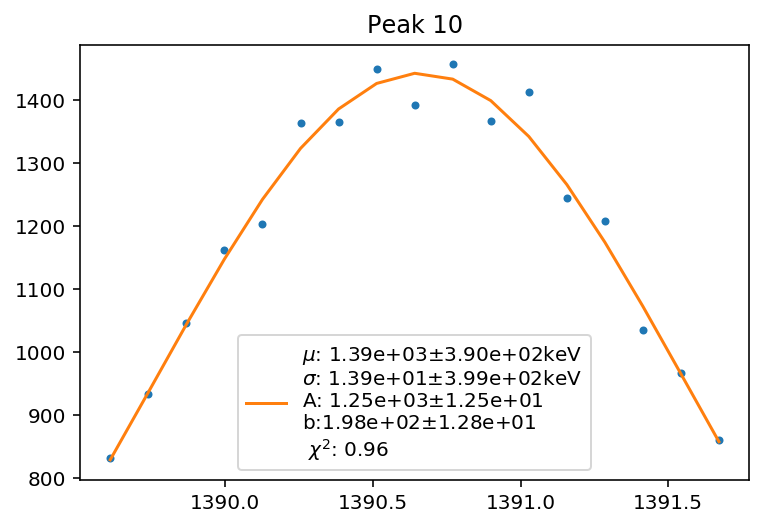

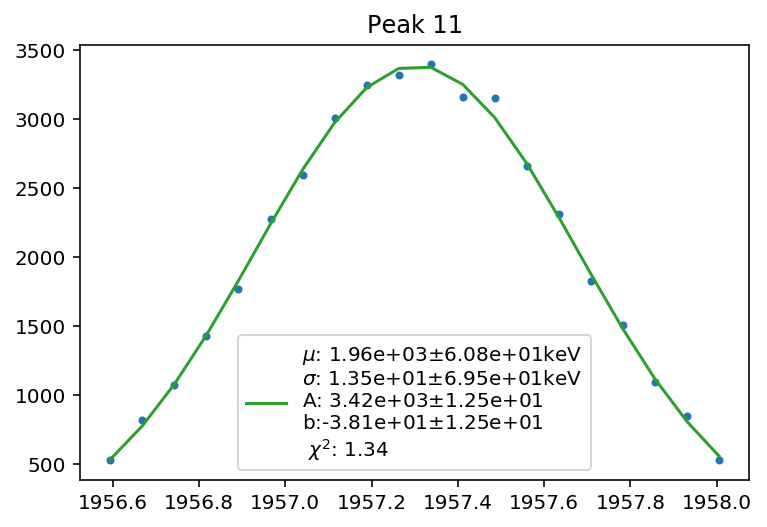

In [185]:
name="Eu152"

totalfig,totalax=plt.subplots(figsize=(20,5))
a,c,peaks1,errors1=fitpeaks(name,1000,totalax,lower=20,width=2,totalaxlimit=60000,lookformore=3,colorcounter=1)
#fitpeaks(name,10000,totalax,lower=500,upper=750,width=20,totalaxlimit=60000,lookformore=3,colorcounter=3,peakcounter=15)
#fitpeaks(name,1000,totalax,lower=250,upper=300,width=1,totalaxlimit=60000,lookformore=3,colorcounter=2,peakcounter=16)
totalax.legend()
totalax.xaxis.set_ticks(np.arange(0,2000,100))
totalax.set_title(name)

In [190]:
m=popt[0]
a=float(popt[1])
b=popt[2]
###b=0
b=0

print(a*2)
dm=perr[0]/popt[0]**2
print(m)

def xInEnergy(x):
    x=np.array(x).astype(float)
    x=x*m+np.square(x)*(-4.878507623893381e-06)-b
    return(x)

-1.1147635995116858e-05
0.20849787050098184


['mu', 'sigma', 'A', 'b']


Text(0.5,1,'Am241')

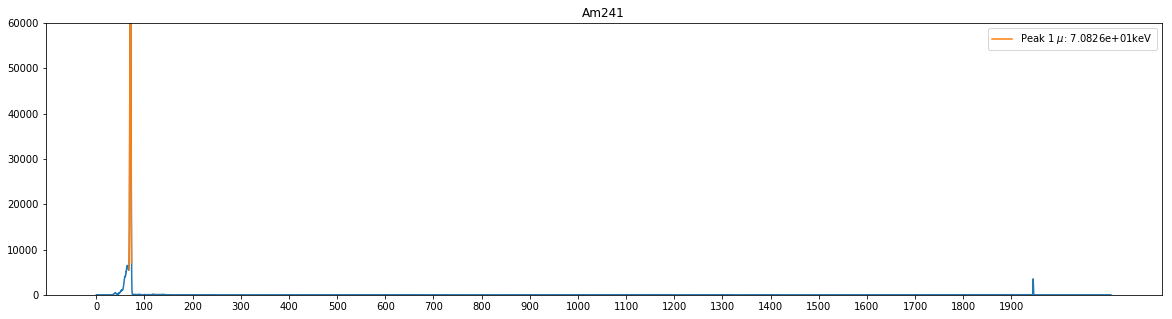

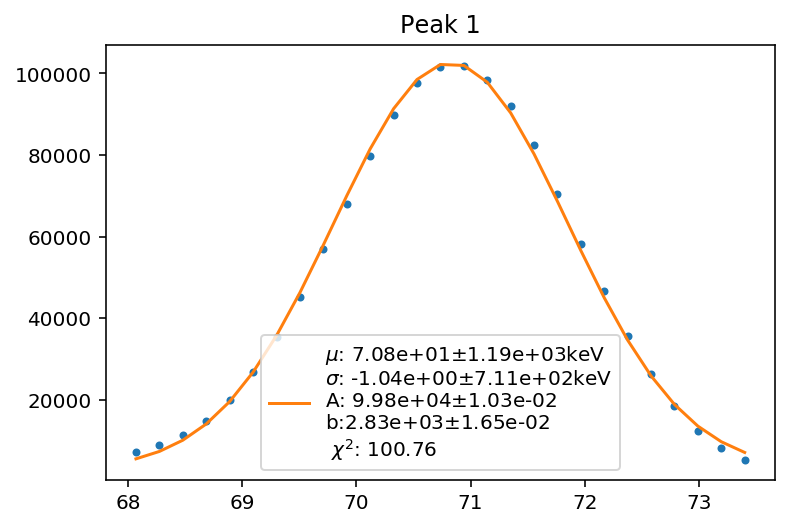

In [191]:
name="Am241"

totalfig,totalax=plt.subplots(figsize=(20,5))
a,c,peaks1,errors1=fitpeaks(name,10000,totalax,lower=20,width=2,totalaxlimit=60000,lookformore=3,colorcounter=1)
#fitpeaks(name,10000,totalax,lower=500,upper=750,width=20,totalaxlimit=60000,lookformore=3,colorcounter=3,peakcounter=15)
#fitpeaks(name,1000,totalax,lower=250,upper=300,width=1,totalaxlimit=60000,lookformore=3,colorcounter=2,peakcounter=16)
totalax.legend()
totalax.xaxis.set_ticks(np.arange(0,2000,100))
totalax.set_title(name)